In [50]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision
# again, this only works on startup!
from jax.config import config
config.update("jax_enable_x64", True)

from util   import *
from basics import *
from simulate_data import *
from estimators    import *
from config import *
from scipy.special import *
configure_pylab()   

# Shadow all pylab functions and numpy with the Jax versions
# Keep numpy around as np0 for easier RNG, array assignments
import jax
import jax.numpy as np
import numpy.random as npr
from jax               import jit, grad, vmap
from jax.config        import config
from jax.scipy.special import logsumexp
from jax.numpy         import *
from jax import jacfwd, jacrev
from jax import lax
from jax.numpy.fft import *
from jax.numpy.linalg import *
fori = lax.fori_loop
def hess(f,inparam):
    return jacfwd(jacrev(f,inparam),inparam)
def hvp(f, x, v):
    return grad(lambda x: vdot(grad(f)(x), v))(x)
import numpy as np0

# redefine these with Jax env so it can be traced
def conv(x,K):
    return real(ifft2(fft2(x.reshape(L,L))*K))
def slog(x,minrate = 1e-10):
    return log(maximum(minrate,x))
def sexp(x,bound = 10):
    return exp(clip(x,-bound,bound))
from numpy.linalg import cholesky as chol
def logdetpsd(Σ):
    return 2*sum(slog(diag(chol(Σ))))
def vec(X):
    return X.ravel()
logdet = lambda A:jax.numpy.linalg.slogdet(A)[1]

# Convolve with vector
def conv(K,v):
    v = v.reshape(L,L)
    return real(ifft2(fft2(v)*K)).ravel()

# Convolve with matrix
def conm(K,M):
    N  = M.shape[-1]
    M  = M.reshape(L,L,N)
    Mf = fft2(M,axes=(0,1))
    Cf = K[:,:,None]*Mf
    C  = real(ifft2(Cf,axes=(0,1)))
    return C.reshape(L*L,N)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simulate grid cell data 

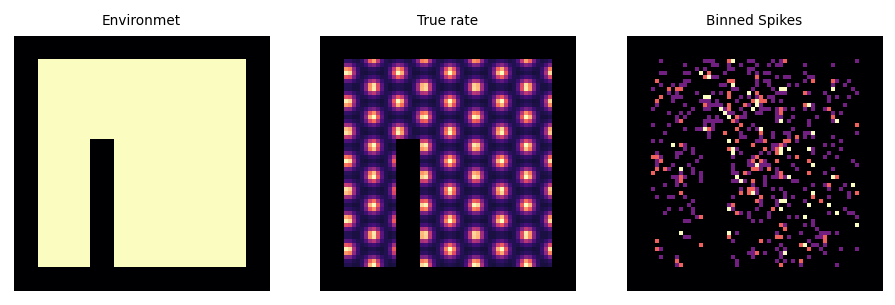

In [76]:
L = 64  # Grid size
P = L/10 # Grid spacing
α = 0.5  # Grid "sharpness"
μ = 1500/L**2 # Mean firing rate (spikes per sample)
mask,λ0,λ0_bg,N,K = simulate_data(L,P,α,μ)
subplot(131); showim(mask,'Environmet')
subplot(132); showim(λ0,'True rate')
subplot(133); showim(K,'Binned Spikes');

fgσ  = P/pi
bgσ  = fgσ*5

# Bessel function
coords = zgrid(L)
kernR  = j0(fftshift(abs(coords*2*pi/P)))
window = hanning(L)
window = outer(window,window)
kernR  = kernR*fftshift(window)
fftkr  = fftshift(real(ifft2(kernR)))

# Restrict kernel to local neighborhood and normalize
k3     = jn_zeros(0,3)[-1]
fwin   = abs(coords)<P*k3/(2*pi)
kern0  = kernR*fftshift(fwin)
kern0  = blur(kern0,P/pi)
kern0  = kern0/np.max(kern0)

# Prepare data
lλb  = slog(kdeλ(N,K,bgσ))     # Log background (initial estimate)
lλf  = slog(kdeλ(N,K,fgσ))-lλb # Log foreground (initial estimate)
n    = N.ravel()               # Number of visits per bin
y    = nan_to_num(K/N).ravel() # Lumped pseudo-observerations
lλb  = lλb.ravel()             # Background offsets

# Low-rank approximation 

## Analytic gradients

In [77]:
from opt_einsum import contract

In [85]:
# Rank of covariance matrix 
R = 5

# Precompute variables; Passed as globals to jac/hess
kern = kern0*zerolag(radial_acorr(lλf,mask))
kern = repair_small_eigenvalues(kern,1e-5)
knft = np0.array(real(fft2(kern)))
knft[0,0] += 1e6
Λ0ft = 1.0/knft

Kf      = knft
Λf      = Λ0ft
M       = cop(Kf)
Λ0      = cop(Λf)
lndΣ0   = sum(log(Kf))

def loss(μ,X):
    λ = exp(μ+μ0+sum(X**2,1)/2)
    ε = λ - y*μ
    trΛ0Σ = sum(X*conm(Λf,X))
    μΛ0μ  = μ.T @ conv(Λf,μ)
    lndΣ  = logdet(X.T@X)
    return n@ε + μΛ0μ/2 + trΛ0Σ/2 + lndΣ0/2 - lndΣ/2

tic('elapsed')

X  = randn(L*L,R)/L**2
μ  = lλf.ravel()
μ0 = lλb.ravel()
mintol,ε,εs,l = 1e-4, inf, [], inf
print( 'loss=%e'%loss(μ,X) )

εv = 1
for iteration in range(100):
    
    for i in range(100):
        λ  = sexp(μ+μ0+sum(X**2,1)/2)
        Jμ = n*(λ-y) + conv(Λf,μ) 
        Hμ = Λ0 + diagop(n*λ)
        Δμ = -minres(Hμ,Jμ,tol=mintol,M=M)[0]
        μ += Δμ
        εμ = np.mean(abs(Δμ)/abs(μ))
        ε = εμ
        oldl = l
        l = loss(μ,X)
        print('μ',iteration,i,'ε=%e'%ε,'mintol=%e'%mintol,'loss=%.20e'%l)
        if oldl<l:
            print('Loss increasing, that\'s bad')
            mintol = maximum(1e-7,mintol/10)
            break
        if ε<εv/100: break
    
    for i in range(3):
        nλ = n*sexp(μ+μ0+sum(X**2,1)/2)
        P  = pinv(X)
        JX = nλ[:,None]*X + conm(Λf,X) - P.T
        def preconditioner(A):
            A = A.reshape(L*L,R)
            return conm(Kf,A).ravel()
        preconditioner = op(L*L*R,preconditioner)
        def hvp(A):
            A    = A.reshape(L*L,R)
            xm   = sum(X*A,1)
            P    = pinv(X)
            Pt   = P.T
            PPt  = P@Pt
            #dpnv = Pt@(M.T@Pt+(X.T@M)@PPt) - M@PPt
            dpnv = contract('ji,kj,lk->il',P,A,P)+\
                   contract('ji,kj,km,mn,ln->il',P,X,A,P,P)-\
                   contract('ij,jk,lk->il',A,P,P)
            return (nλ[:,None]*(A + xm[:,None]*X) + conm(Λf,A) + dpnv).ravel()
        HX = op(L*L*R,hvp)
        #M=preconditioner
        ΔX = -minres(HX,JX.ravel(),tol=mintol)[0]
        ΔX = ΔX.reshape(X.shape)
        X += ΔX
        εv = np.mean(abs(ΔX))/mean(abs(X))
        ε = εv
        oldl = l
        l = loss(μ,X)
        print('X',iteration,i,'ε=%e'%ε,'mintol=%e'%mintol,'loss=%.20e'%l)
        if oldl<l:
            print('Loss increasing, that\'s bad')
            mintol = maximum(1e-7,mintol/10)
            break
tic('elapsed')
subplot(141); showkn(kern,'Kernel');
subplot(142); showim(np0.array(y),'Observations');
subplot(143); showim(μ,'Post. Log-Rate',mask=mask);
subplot(144); showim(sum(X**2,1),'Post. variance',mask=mask);
μ_=μ
X_=X

Δt = 5218 ms  elapsed for elapsed
loss=2.588384e+06
μ 0 0 ε=7.308429e+00 mintol=1.000000e-04 loss=-1.54815327179008290841e+04
μ 0 1 ε=3.533223e+00 mintol=1.000000e-04 loss=-1.54842879337632712122e+04
μ 0 2 ε=2.728196e+00 mintol=1.000000e-04 loss=-1.55068174601320770307e+04
μ 0 3 ε=8.311825e-01 mintol=1.000000e-04 loss=-1.55069068328170378663e+04
μ 0 4 ε=8.310180e-01 mintol=1.000000e-04 loss=-1.55100233302929718775e+04
μ 0 5 ε=5.408571e-02 mintol=1.000000e-04 loss=-1.55100246713514115982e+04
μ 0 6 ε=1.588402e-01 mintol=1.000000e-04 loss=-1.55102136334178103425e+04
μ 0 7 ε=6.936637e-02 mintol=1.000000e-04 loss=-1.55102544159547305753e+04
μ 0 8 ε=2.686778e-02 mintol=1.000000e-04 loss=-1.55102644513338491379e+04
μ 0 9 ε=2.488594e-02 mintol=1.000000e-04 loss=-1.55102673447186098201e+04
μ 0 10 ε=2.693860e-02 mintol=1.000000e-04 loss=-1.55102681289445663424e+04
μ 0 11 ε=5.733160e-03 mintol=1.000000e-04 loss=-1.55102683713009009807e+04
X 0 0 ε=1.007581e+00 mintol=1.000000e-04 loss=-1.545075067

KeyboardInterrupt: 

Δt = 4325 ms  elapsed for elapsed
loss=2.487818e+05
μ 0 0 ε=1.436362e+01 mintol=1.000000e-04 loss=-1.20314429297943152051e+04
μ 0 1 ε=4.980252e+00 mintol=1.000000e-04 loss=-1.20338003389945606614e+04
μ 0 2 ε=2.953694e-02 mintol=1.000000e-04 loss=-1.20338019620657833002e+04
μ 0 3 ε=3.869628e-05 mintol=1.000000e-04 loss=-1.20338019620738486992e+04
μ 0 4 ε=4.621638e-08 mintol=1.000000e-04 loss=-1.20338019620738486992e+04
X 0 0 ε=4.920827e-01 mintol=1.000000e-04 loss=-1.20344507182866182120e+04
X 0 1 ε=5.105311e-01 mintol=1.000000e-04 loss=-1.20351548434255691973e+04
X 0 2 ε=3.669447e-01 mintol=1.000000e-04 loss=-1.20355676756697466772e+04
X 0 3 ε=1.800542e-01 mintol=1.000000e-04 loss=-1.20357316416574303730e+04
X 0 4 ε=1.246995e-01 mintol=1.000000e-04 loss=-1.20358268139553456422e+04


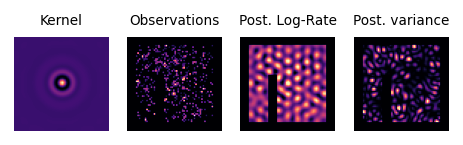

μ 1 0 ε=2.109363e-05 mintol=1.000000e-04 loss=-1.20358268139558913390e+04
X 1 0 ε=1.181510e-01 mintol=1.000000e-04 loss=-1.20359061628380259208e+04
X 1 1 ε=9.713566e-02 mintol=1.000000e-04 loss=-1.20359693078278560279e+04
X 1 2 ε=3.959223e-02 mintol=1.000000e-04 loss=-1.20359955245767268934e+04
X 1 3 ε=1.675882e-01 mintol=1.000000e-04 loss=-1.20361341238040131429e+04
X 1 4 ε=5.771888e-02 mintol=1.000000e-04 loss=-1.20361651031207602500e+04


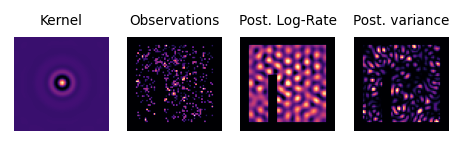

μ 2 0 ε=2.288624e-05 mintol=1.000000e-04 loss=-1.20361651031214078102e+04
X 2 0 ε=8.527302e-02 mintol=1.000000e-04 loss=-1.20362229448620910262e+04
X 2 1 ε=9.117722e-02 mintol=1.000000e-04 loss=-1.20362833435081938660e+04
X 2 2 ε=9.636343e-02 mintol=1.000000e-04 loss=-1.20363479342798964353e+04
X 2 3 ε=1.394102e-01 mintol=1.000000e-04 loss=-1.20364402489000840433e+04
X 2 4 ε=7.673293e-02 mintol=1.000000e-04 loss=-1.20364875111984092655e+04


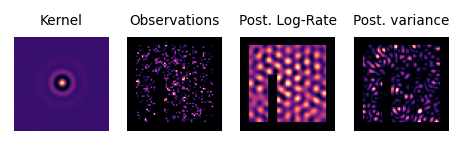

μ 3 0 ε=4.306301e-05 mintol=1.000000e-04 loss=-1.20364875112010631710e+04
X 3 0 ε=6.315987e-02 mintol=1.000000e-04 loss=-1.20365264898560180882e+04
X 3 1 ε=5.331666e-02 mintol=1.000000e-04 loss=-1.20365603321955259162e+04
X 3 2 ε=5.480508e-02 mintol=1.000000e-04 loss=-1.20365968406593547115e+04
X 3 3 ε=4.250303e-02 mintol=1.000000e-04 loss=-1.20366255145210761839e+04
X 3 4 ε=4.134763e-02 mintol=1.000000e-04 loss=-1.20366538385119238228e+04


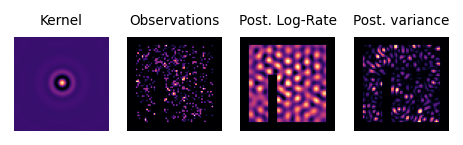

μ 4 0 ε=4.395042e-05 mintol=1.000000e-04 loss=-1.20366538385145977372e+04
X 4 0 ε=3.802126e-02 mintol=1.000000e-04 loss=-1.20366795265824293892e+04
X 4 1 ε=3.790128e-02 mintol=1.000000e-04 loss=-1.20367047267703255784e+04
X 4 2 ε=3.386025e-02 mintol=1.000000e-04 loss=-1.20367265270906445949e+04
X 4 3 ε=3.169296e-02 mintol=1.000000e-04 loss=-1.20367465858782961732e+04
X 4 4 ε=3.102044e-02 mintol=1.000000e-04 loss=-1.20367657745702035754e+04


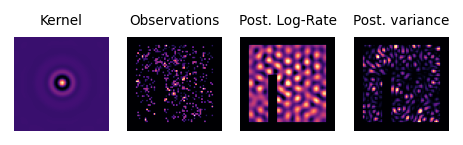

μ 5 0 ε=3.967885e-05 mintol=1.000000e-04 loss=-1.20367657745723026892e+04
X 5 0 ε=2.940019e-02 mintol=1.000000e-04 loss=-1.20367837902536484762e+04
X 5 1 ε=2.847193e-02 mintol=1.000000e-04 loss=-1.20368009465425748203e+04
X 5 2 ε=2.651821e-02 mintol=1.000000e-04 loss=-1.20368168638263814501e+04
X 5 3 ε=2.555059e-02 mintol=1.000000e-04 loss=-1.20368320268553361529e+04
X 5 4 ε=3.099145e-01 mintol=1.000000e-04 loss=-1.20370112383705436514e+04


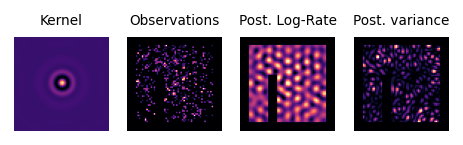

μ 6 0 ε=1.988302e-04 mintol=1.000000e-04 loss=-1.20370112384229396412e+04
X 6 0 ε=1.388194e-02 mintol=1.000000e-04 loss=-1.20370154195448831160e+04
X 6 1 ε=1.645879e-02 mintol=1.000000e-04 loss=-1.20370205946829883032e+04
X 6 2 ε=1.382372e-02 mintol=1.000000e-04 loss=-1.20370250094935690868e+04
X 6 3 ε=1.035913e-02 mintol=1.000000e-04 loss=-1.20370284639075562154e+04
X 6 4 ε=1.040577e-02 mintol=1.000000e-04 loss=-1.20370320692870063795e+04


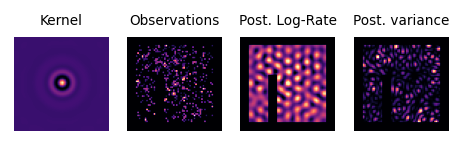

μ 7 0 ε=1.743005e-05 mintol=1.000000e-04 loss=-1.20370320692876375688e+04
X 7 0 ε=9.406904e-03 mintol=1.000000e-04 loss=-1.20370355038481884549e+04
X 7 1 ε=3.268314e-02 mintol=1.000000e-04 loss=-1.20370478109189771203e+04
X 7 2 ε=1.300227e-02 mintol=1.000000e-04 loss=-1.20370532509254808247e+04
X 7 3 ε=7.216688e-03 mintol=1.000000e-04 loss=-1.20370561916447622934e+04
X 7 4 ε=7.254659e-03 mintol=1.000000e-04 loss=-1.20370591053757452755e+04


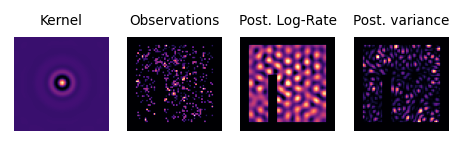

μ 8 0 ε=4.342446e-05 mintol=1.000000e-04 loss=-1.20370591053783537063e+04
X 8 0 ε=6.340329e-03 mintol=1.000000e-04 loss=-1.20370616214929268608e+04
X 8 1 ε=6.458010e-03 mintol=1.000000e-04 loss=-1.20370641482883693243e+04
X 8 2 ε=1.000004e-02 mintol=1.000000e-04 loss=-1.20370680493939762528e+04
X 8 3 ε=5.952371e-03 mintol=1.000000e-04 loss=-1.20370703033176250756e+04
X 8 4 ε=5.781619e-03 mintol=1.000000e-04 loss=-1.20370724830578983529e+04


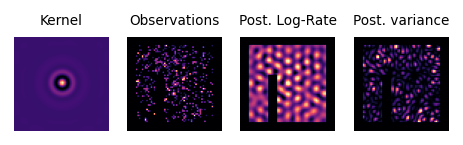

μ 9 0 ε=2.679312e-05 mintol=1.000000e-04 loss=-1.20370724830588333134e+04
X 9 0 ε=7.580332e-03 mintol=1.000000e-04 loss=-1.20370753077159788518e+04
X 9 1 ε=9.814920e-03 mintol=1.000000e-04 loss=-1.20370789350613904389e+04
X 9 2 ε=6.007877e-03 mintol=1.000000e-04 loss=-1.20370810983708015556e+04
X 9 3 ε=6.162903e-03 mintol=1.000000e-04 loss=-1.20370833093291239493e+04
X 9 4 ε=5.024304e-03 mintol=1.000000e-04 loss=-1.20370850767969022854e+04


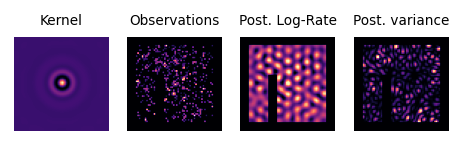

μ 10 0 ε=2.796301e-05 mintol=1.000000e-04 loss=-1.20370850767979227385e+04
X 10 0 ε=4.644511e-03 mintol=1.000000e-04 loss=-1.20370867064788180869e+04
X 10 1 ε=4.632390e-03 mintol=1.000000e-04 loss=-1.20370883101463623461e+04
X 10 2 ε=4.701457e-03 mintol=1.000000e-04 loss=-1.20370899363339103729e+04
X 10 3 ε=4.280485e-03 mintol=1.000000e-04 loss=-1.20370913956907297688e+04
X 10 4 ε=4.307049e-03 mintol=1.000000e-04 loss=-1.20370928639829344320e+04


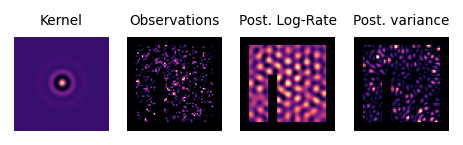

μ 11 0 ε=1.816654e-05 mintol=1.000000e-04 loss=-1.20370928639833691705e+04
X 11 0 ε=5.416533e-03 mintol=1.000000e-04 loss=-1.20370946954118917347e+04
X 11 1 ε=4.181822e-03 mintol=1.000000e-04 loss=-1.20370961012053467130e+04
X 11 2 ε=4.009634e-03 mintol=1.000000e-04 loss=-1.20370974342211156909e+04
X 11 3 ε=3.859040e-03 mintol=1.000000e-04 loss=-1.20370987168467054289e+04
X 11 4 ε=4.540479e-03 mintol=1.000000e-04 loss=-1.20371002149724190531e+04


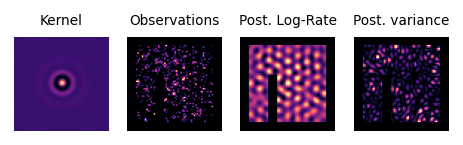

μ 12 0 ε=1.773306e-05 mintol=1.000000e-04 loss=-1.20371002149728337827e+04
X 12 0 ε=1.054288e-02 mintol=1.000000e-04 loss=-1.20371036843944875727e+04
X 12 1 ε=3.772447e-03 mintol=1.000000e-04 loss=-1.20371049049822249799e+04
X 12 2 ε=3.537045e-03 mintol=1.000000e-04 loss=-1.20371060486893074994e+04
X 12 3 ε=3.668022e-03 mintol=1.000000e-04 loss=-1.20371072281990163901e+04
X 12 4 ε=3.407550e-03 mintol=1.000000e-04 loss=-1.20371083216780862131e+04


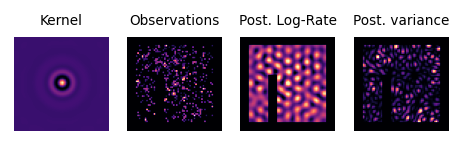

μ 13 0 ε=1.942885e-05 mintol=1.000000e-04 loss=-1.20371083216785955301e+04
X 13 0 ε=3.543072e-03 mintol=1.000000e-04 loss=-1.20371094542715200078e+04
X 13 1 ε=4.322041e-02 mintol=1.000000e-04 loss=-1.20371229580652816367e+04
X 13 2 ε=6.285679e-03 mintol=1.000000e-04 loss=-1.20371248876563840895e+04
X 13 3 ε=3.277976e-03 mintol=1.000000e-04 loss=-1.20371258876448828232e+04
X 13 4 ε=3.016552e-03 mintol=1.000000e-04 loss=-1.20371268080611371261e+04


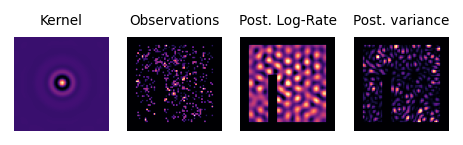

μ 14 0 ε=4.419679e-05 mintol=1.000000e-04 loss=-1.20371268080638819811e+04
μ 14 1 ε=3.806566e-08 mintol=1.000000e-04 loss=-1.20371268080638838001e+04
X 14 0 ε=2.828790e-03 mintol=1.000000e-04 loss=-1.20371276682991756388e+04
X 14 1 ε=3.992402e-03 mintol=1.000000e-04 loss=-1.20371288846735715197e+04
X 14 2 ε=3.298371e-03 mintol=1.000000e-04 loss=-1.20371298860591014090e+04
X 14 3 ε=3.655477e-03 mintol=1.000000e-04 loss=-1.20371309967193155899e+04
X 14 4 ε=3.210578e-03 mintol=1.000000e-04 loss=-1.20371319692082215624e+04


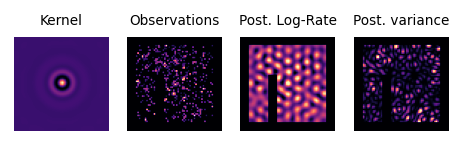

μ 15 0 ε=9.003455e-06 mintol=1.000000e-04 loss=-1.20371319692083634436e+04
X 15 0 ε=3.593277e-03 mintol=1.000000e-04 loss=-1.20371330584880652168e+04
X 15 1 ε=3.165634e-03 mintol=1.000000e-04 loss=-1.20371340157836184517e+04
X 15 2 ε=3.533486e-03 mintol=1.000000e-04 loss=-1.20371350849547525286e+04
X 15 3 ε=3.125074e-03 mintol=1.000000e-04 loss=-1.20371360284682868951e+04
X 15 4 ε=3.480753e-03 mintol=1.000000e-04 loss=-1.20371370802842920966e+04


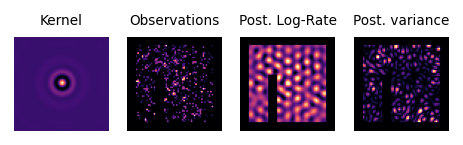

μ 16 0 ε=8.184526e-06 mintol=1.000000e-04 loss=-1.20371370802844194259e+04
X 16 0 ε=3.093881e-03 mintol=1.000000e-04 loss=-1.20371380131548266945e+04
X 16 1 ε=3.436609e-03 mintol=1.000000e-04 loss=-1.20371390507563137362e+04
X 16 2 ε=3.065139e-03 mintol=1.000000e-04 loss=-1.20371399742283610976e+04
X 16 3 ε=3.392944e-03 mintol=1.000000e-04 loss=-1.20371409984023375728e+04
X 16 4 ε=3.037528e-03 mintol=1.000000e-04 loss=-1.20371419134659972769e+04


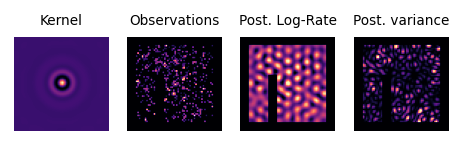

μ 17 0 ε=7.028822e-06 mintol=1.000000e-04 loss=-1.20371419134661009593e+04
X 17 0 ε=3.349914e-03 mintol=1.000000e-04 loss=-1.20371429248707518127e+04
X 17 1 ε=3.011904e-03 mintol=1.000000e-04 loss=-1.20371438325499202620e+04
X 17 2 ε=3.308025e-03 mintol=1.000000e-04 loss=-1.20371448317069425684e+04
X 17 3 ε=2.989108e-03 mintol=1.000000e-04 loss=-1.20371457330901885143e+04
X 17 4 ε=3.267047e-03 mintol=1.000000e-04 loss=-1.20371467204348737141e+04


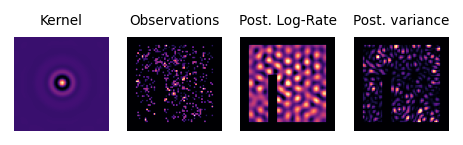

μ 18 0 ε=6.502941e-06 mintol=1.000000e-04 loss=-1.20371467204349683016e+04
X 18 0 ε=2.969431e-03 mintol=1.000000e-04 loss=-1.20371476166434240440e+04
X 18 1 ε=3.226382e-03 mintol=1.000000e-04 loss=-1.20371485924632761453e+04
X 18 2 ε=2.952223e-03 mintol=1.000000e-04 loss=-1.20371494845308025106e+04
X 18 3 ε=3.185154e-03 mintol=1.000000e-04 loss=-1.20371504489027192903e+04
X 18 4 ε=2.937114e-03 mintol=1.000000e-04 loss=-1.20371513376422335568e+04


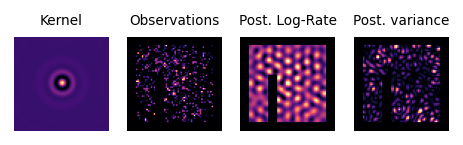

μ 19 0 ε=5.773069e-06 mintol=1.000000e-04 loss=-1.20371513376423154114e+04
X 19 0 ε=3.142494e-03 mintol=1.000000e-04 loss=-1.20371522903539989784e+04
X 19 1 ε=2.922647e-03 mintol=1.000000e-04 loss=-1.20371531761700280185e+04
X 19 2 ε=3.097081e-03 mintol=1.000000e-04 loss=-1.20371541164974169078e+04
X 19 3 ε=2.906780e-03 mintol=1.000000e-04 loss=-1.20371549991175270407e+04
X 19 4 ε=7.841030e-04 mintol=1.000000e-04 loss=-1.20371552371471752849e+04


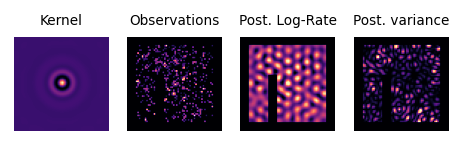

μ 20 0 ε=4.627576e-06 mintol=1.000000e-04 loss=-1.20371552371472316736e+04
X 20 0 ε=3.175424e-03 mintol=1.000000e-04 loss=-1.20371562028265416302e+04
X 20 1 ε=1.477445e-03 mintol=1.000000e-04 loss=-1.20371566523549790872e+04
X 20 2 ε=1.851223e-03 mintol=1.000000e-04 loss=-1.20371572156950805947e+04
X 20 3 ε=2.752107e-03 mintol=1.000000e-04 loss=-1.20371580546059758490e+04
X 20 4 ε=2.607073e-03 mintol=1.000000e-04 loss=-1.20371588496733184002e+04


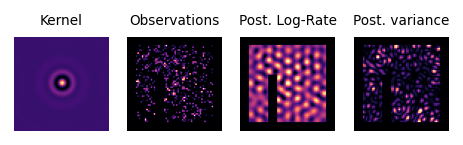

μ 21 0 ε=4.082242e-06 mintol=1.000000e-04 loss=-1.20371588496733638749e+04
X 21 0 ε=1.707112e-03 mintol=1.000000e-04 loss=-1.20371593707779029501e+04
X 21 1 ε=4.904236e-03 mintol=1.000000e-04 loss=-1.20371608701680288505e+04
X 21 2 ε=9.367613e-04 mintol=1.000000e-04 loss=-1.20371611567212166847e+04
X 21 3 ε=3.059562e-03 mintol=1.000000e-04 loss=-1.20371620935509363335e+04
X 21 4 ε=8.769028e-04 mintol=1.000000e-04 loss=-1.20371623621897124394e+04


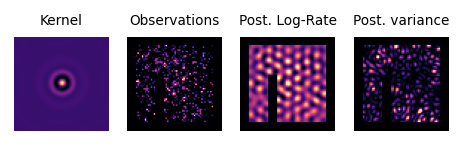

μ 22 0 ε=3.837701e-06 mintol=1.000000e-04 loss=-1.20371623621897524572e+04
X 22 0 ε=1.703320e-03 mintol=1.000000e-04 loss=-1.20371628843037597107e+04
X 22 1 ε=8.584269e-04 mintol=1.000000e-04 loss=-1.20371631475893427705e+04
X 22 2 ε=1.336031e-03 mintol=1.000000e-04 loss=-1.20371635575102991425e+04
X 22 3 ε=2.104798e-04 mintol=1.000000e-04 loss=-1.20371636221158114495e+04
X 22 4 ε=6.117799e-05 mintol=1.000000e-04 loss=-1.20371636408919202950e+04


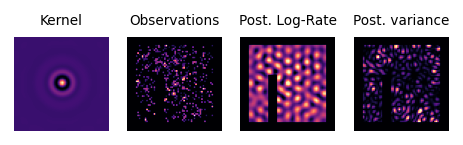

μ 23 0 ε=1.356193e-06 mintol=1.000000e-04 loss=-1.20371636408919239329e+04
μ 23 1 ε=9.283033e-10 mintol=1.000000e-04 loss=-1.20371636408919239329e+04
X 23 0 ε=1.615340e-05 mintol=1.000000e-04 loss=-1.20371636458497359854e+04
X 23 1 ε=1.252969e-03 mintol=1.000000e-04 loss=-1.20371640305965138396e+04
X 23 2 ε=7.073948e-05 mintol=1.000000e-04 loss=-1.20371640523185451457e+04
X 23 3 ε=1.109095e-04 mintol=1.000000e-04 loss=-1.20371640863785160036e+04
X 23 4 ε=3.193044e-05 mintol=1.000000e-04 loss=-1.20371640961840585078e+04


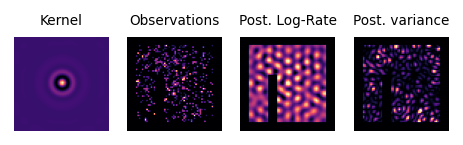

μ 24 0 ε=4.807901e-07 mintol=1.000000e-04 loss=-1.20371640961840603268e+04
μ 24 1 ε=3.282304e-10 mintol=1.000000e-04 loss=-1.20371640961840585078e+04
Loss increasing, that's bad
X 24 0 ε=7.979012e-04 mintol=1.000000e-05 loss=-1.20371643412902449199e+04
X 24 1 ε=3.678306e-04 mintol=1.000000e-05 loss=-1.20371644543139591406e+04
X 24 2 ε=1.774508e-04 mintol=1.000000e-05 loss=-1.20371645088450986805e+04
X 24 3 ε=1.243488e-04 mintol=1.000000e-05 loss=-1.20371645470599214605e+04
X 24 4 ε=4.680917e-05 mintol=1.000000e-05 loss=-1.20371645614457502234e+04


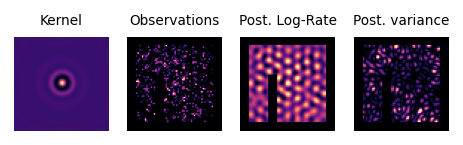

μ 25 0 ε=4.872429e-07 mintol=1.000000e-05 loss=-1.20371645614457520423e+04
μ 25 1 ε=2.630451e-11 mintol=1.000000e-05 loss=-1.20371645614457520423e+04
X 25 0 ε=2.802765e-05 mintol=1.000000e-05 loss=-1.20371645700596363895e+04
X 25 1 ε=1.407371e-05 mintol=1.000000e-05 loss=-1.20371645743849821883e+04
X 25 2 ε=6.367549e-06 mintol=1.000000e-05 loss=-1.20371645763419710420e+04
X 25 3 ε=2.731898e-06 mintol=1.000000e-05 loss=-1.20371645771815838089e+04
X 25 4 ε=1.509461e-06 mintol=1.000000e-05 loss=-1.20371645776454988663e+04


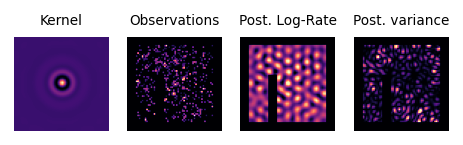

μ 26 0 ε=1.692329e-08 mintol=1.000000e-05 loss=-1.20371645776454970473e+04
Loss increasing, that's bad
μ 26 1 ε=9.160977e-13 mintol=1.000000e-06 loss=-1.20371645776454970473e+04
X 26 0 ε=2.469214e-01 mintol=1.000000e-06 loss=-1.20370967414943152107e+04
Loss increasing, that's bad
X 26 1 ε=4.557856e-01 mintol=1.000000e-07 loss=-1.20370323681683148607e+04
Loss increasing, that's bad
X 26 2 ε=1.908583e-01 mintol=1.000000e-07 loss=-1.20370420165475425165e+04
X 26 3 ε=2.824801e-01 mintol=1.000000e-07 loss=-1.20370211898382658546e+04
Loss increasing, that's bad
X 26 4 ε=1.243784e-01 mintol=1.000000e-07 loss=-1.20370202650315277424e+04
Loss increasing, that's bad


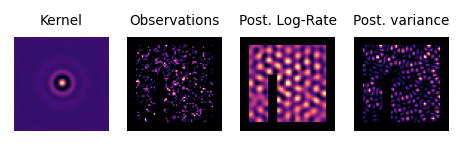

μ 27 0 ε=1.613942e-04 mintol=1.000000e-07 loss=-1.20370202651913969021e+04
X 27 0 ε=1.522804e-01 mintol=1.000000e-07 loss=-1.20370152968208676612e+04
Loss increasing, that's bad
X 27 1 ε=8.547447e-02 mintol=1.000000e-07 loss=-1.20370137432899682608e+04
Loss increasing, that's bad
X 27 2 ε=7.158248e-02 mintol=1.000000e-07 loss=-1.20370124923246239632e+04
Loss increasing, that's bad
X 27 3 ε=5.475011e-02 mintol=1.000000e-07 loss=-1.20370119303153223882e+04
Loss increasing, that's bad
X 27 4 ε=4.070587e-02 mintol=1.000000e-07 loss=-1.20370115132843930041e+04
Loss increasing, that's bad


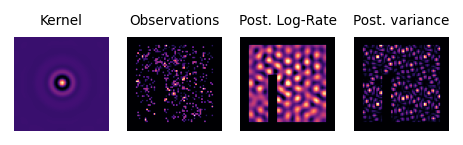

μ 28 0 ε=6.684905e-05 mintol=1.000000e-07 loss=-1.20370115133258877904e+04
X 28 0 ε=3.304103e-02 mintol=1.000000e-07 loss=-1.20370113080415467266e+04
Loss increasing, that's bad
X 28 1 ε=2.198810e-02 mintol=1.000000e-07 loss=-1.20370111649228165334e+04
Loss increasing, that's bad
X 28 2 ε=2.158181e-02 mintol=1.000000e-07 loss=-1.20370110372747276415e+04
Loss increasing, that's bad
X 28 3 ε=1.820869e-02 mintol=1.000000e-07 loss=-1.20370109352037106873e+04
Loss increasing, that's bad
X 28 4 ε=1.745099e-02 mintol=1.000000e-07 loss=-1.20370108438786974148e+04
Loss increasing, that's bad


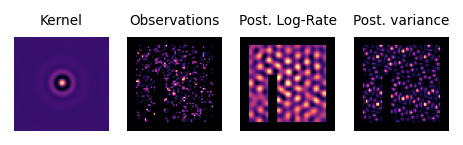

μ 29 0 ε=2.102454e-05 mintol=1.000000e-07 loss=-1.20370108438817005663e+04
X 29 0 ε=1.624668e-02 mintol=1.000000e-07 loss=-1.20370107600088376785e+04
Loss increasing, that's bad
X 29 1 ε=1.873147e-02 mintol=1.000000e-07 loss=-1.20370106654319733934e+04
Loss increasing, that's bad
X 29 2 ε=1.489893e-02 mintol=1.000000e-07 loss=-1.20370107284743189666e+04
X 29 3 ε=1.457347e-02 mintol=1.000000e-07 loss=-1.20370107992783960071e+04
X 29 4 ε=1.669248e-02 mintol=1.000000e-07 loss=-1.20370108794923526148e+04


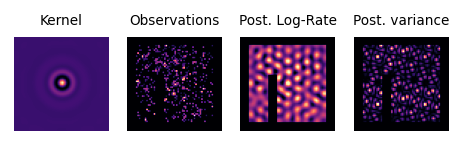

μ 30 0 ε=4.030519e-06 mintol=1.000000e-07 loss=-1.20370108794925763505e+04
X 30 0 ε=1.552198e-02 mintol=1.000000e-07 loss=-1.20370109439502484747e+04
X 30 1 ε=1.469693e-02 mintol=1.000000e-07 loss=-1.20370110125431438064e+04
X 30 2 ε=1.362182e-02 mintol=1.000000e-07 loss=-1.20370110751263928250e+04
X 30 3 ε=1.267113e-02 mintol=1.000000e-07 loss=-1.20370111292354195029e+04
X 30 4 ε=1.444139e-02 mintol=1.000000e-07 loss=-1.20370111947467576101e+04


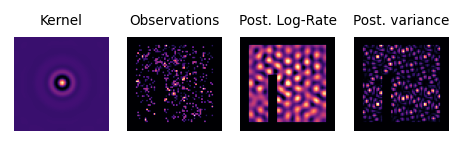

μ 31 0 ε=1.465314e-05 mintol=1.000000e-07 loss=-1.20370111947481782408e+04
X 31 0 ε=1.366988e-02 mintol=1.000000e-07 loss=-1.20370112540715672367e+04
X 31 1 ε=1.172770e-02 mintol=1.000000e-07 loss=-1.20370113036594575533e+04
X 31 2 ε=1.383830e-02 mintol=1.000000e-07 loss=-1.20370113648270817066e+04
X 31 3 ε=1.313107e-02 mintol=1.000000e-07 loss=-1.20370114178996245755e+04
X 31 4 ε=1.259460e-02 mintol=1.000000e-07 loss=-1.20370114723421629606e+04


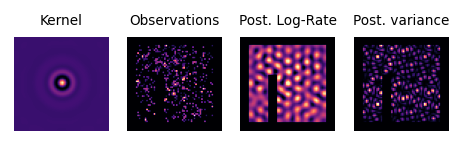

μ 32 0 ε=1.237920e-05 mintol=1.000000e-07 loss=-1.20370114723432525352e+04
X 32 0 ε=1.352050e-02 mintol=1.000000e-07 loss=-1.20370115257413672225e+04
X 32 1 ε=1.288037e-02 mintol=1.000000e-07 loss=-1.20370115803553344449e+04
X 32 2 ε=1.363588e-02 mintol=1.000000e-07 loss=-1.20370116331176941458e+04
X 32 3 ε=1.258884e-02 mintol=1.000000e-07 loss=-1.20370116854141979275e+04
X 32 4 ε=1.770702e-02 mintol=1.000000e-07 loss=-1.20370117529749713867e+04


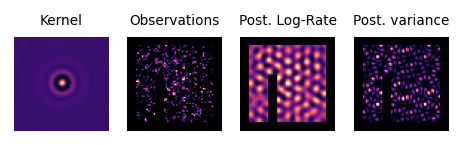

μ 33 0 ε=1.241860e-05 mintol=1.000000e-07 loss=-1.20370117529762028425e+04
X 33 0 ε=1.334403e-02 mintol=1.000000e-07 loss=-1.20370118071831511770e+04
X 33 1 ε=1.224185e-02 mintol=1.000000e-07 loss=-1.20370118524205699941e+04
X 33 2 ε=1.305403e-02 mintol=1.000000e-07 loss=-1.20370119045300089056e+04
X 33 3 ε=1.128598e-02 mintol=1.000000e-07 loss=-1.20370119438901783724e+04
X 33 4 ε=1.201908e-02 mintol=1.000000e-07 loss=-1.20370119911092169787e+04


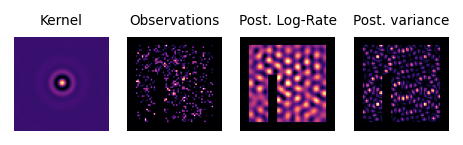

μ 34 0 ε=1.019370e-05 mintol=1.000000e-07 loss=-1.20370119911100955505e+04
X 34 0 ε=1.419189e-02 mintol=1.000000e-07 loss=-1.20370120414833472751e+04
X 34 1 ε=1.224525e-02 mintol=1.000000e-07 loss=-1.20370120887667708303e+04
X 34 2 ε=1.266976e-02 mintol=1.000000e-07 loss=-1.20370121317303219257e+04
X 34 3 ε=1.186539e-02 mintol=1.000000e-07 loss=-1.20370121768402277667e+04
X 34 4 ε=1.093794e-02 mintol=1.000000e-07 loss=-1.20370122075413910352e+04


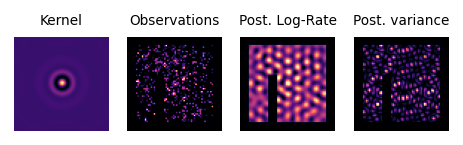

μ 35 0 ε=9.582791e-06 mintol=1.000000e-07 loss=-1.20370122075422787020e+04
X 35 0 ε=1.013611e-02 mintol=1.000000e-07 loss=-1.20370122380729462748e+04
X 35 1 ε=1.479901e-02 mintol=1.000000e-07 loss=-1.20370122860533138009e+04
X 35 2 ε=1.258037e-03 mintol=1.000000e-07 loss=-1.20370122881170445908e+04
X 35 3 ε=1.121265e-02 mintol=1.000000e-07 loss=-1.20370122876822933904e+04
Loss increasing, that's bad
X 35 4 ε=1.591384e-02 mintol=1.000000e-07 loss=-1.20370122304771848576e+04
Loss increasing, that's bad


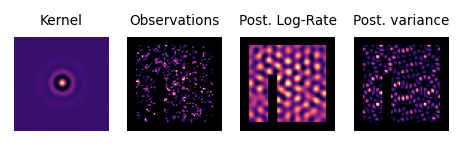

μ 36 0 ε=4.783062e-06 mintol=1.000000e-07 loss=-1.20370122304773722135e+04
X 36 0 ε=9.560832e-03 mintol=1.000000e-07 loss=-1.20370122596969158622e+04
X 36 1 ε=1.696957e-02 mintol=1.000000e-07 loss=-1.20370121994475139218e+04
Loss increasing, that's bad
X 36 2 ε=9.604226e-03 mintol=1.000000e-07 loss=-1.20370122125253783452e+04
X 36 3 ε=1.062101e-02 mintol=1.000000e-07 loss=-1.20370121756274384097e+04
Loss increasing, that's bad
X 36 4 ε=1.011915e-02 mintol=1.000000e-07 loss=-1.20370121416833990224e+04
Loss increasing, that's bad


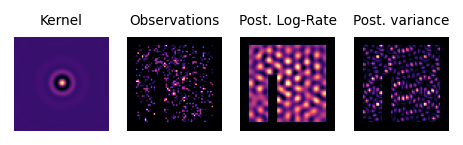

μ 37 0 ε=5.203570e-06 mintol=1.000000e-07 loss=-1.20370121416835881973e+04
X 37 0 ε=3.417480e-03 mintol=1.000000e-07 loss=-1.20370121305336415389e+04
Loss increasing, that's bad
X 37 1 ε=1.083607e-02 mintol=1.000000e-07 loss=-1.20370120941610548471e+04
Loss increasing, that's bad
X 37 2 ε=1.059247e-02 mintol=1.000000e-07 loss=-1.20370121060034089169e+04
X 37 3 ε=8.570787e-03 mintol=1.000000e-07 loss=-1.20370121114059747924e+04
X 37 4 ε=1.004226e-02 mintol=1.000000e-07 loss=-1.20370120782272497308e+04
Loss increasing, that's bad


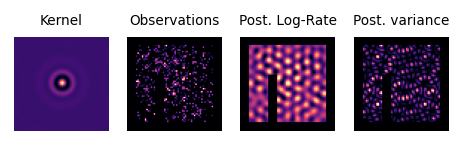

μ 38 0 ε=5.038105e-06 mintol=1.000000e-07 loss=-1.20370120782274207158e+04
X 38 0 ε=9.632719e-03 mintol=1.000000e-07 loss=-1.20370120700185307214e+04
Loss increasing, that's bad
X 38 1 ε=9.302974e-03 mintol=1.000000e-07 loss=-1.20370120401461517758e+04
Loss increasing, that's bad
X 38 2 ε=9.382864e-03 mintol=1.000000e-07 loss=-1.20370120294574226136e+04
Loss increasing, that's bad
X 38 3 ε=8.508893e-03 mintol=1.000000e-07 loss=-1.20370120029554745997e+04
Loss increasing, that's bad
X 38 4 ε=4.942819e-03 mintol=1.000000e-07 loss=-1.20370120187277825607e+04


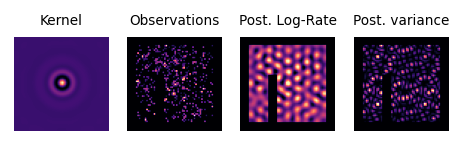

μ 39 0 ε=4.490581e-06 mintol=1.000000e-07 loss=-1.20370120187279226229e+04
X 39 0 ε=1.001228e-02 mintol=1.000000e-07 loss=-1.20370119940202275757e+04
Loss increasing, that's bad
X 39 1 ε=8.198057e-03 mintol=1.000000e-07 loss=-1.20370120112633267127e+04
X 39 2 ε=8.833501e-03 mintol=1.000000e-07 loss=-1.20370119839677827258e+04
Loss increasing, that's bad
X 39 3 ε=9.001506e-03 mintol=1.000000e-07 loss=-1.20370119888567860471e+04
X 39 4 ε=9.275951e-03 mintol=1.000000e-07 loss=-1.20370120134206608782e+04


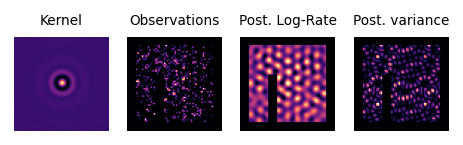

μ 40 0 ε=4.826340e-06 mintol=1.000000e-07 loss=-1.20370120134208300442e+04
X 40 0 ε=1.053967e-02 mintol=1.000000e-07 loss=-1.20370119816753885971e+04
Loss increasing, that's bad
X 40 1 ε=7.799567e-03 mintol=1.000000e-07 loss=-1.20370119848535687197e+04
X 40 2 ε=9.263259e-03 mintol=1.000000e-07 loss=-1.20370119576619617874e+04
Loss increasing, that's bad
X 40 3 ε=9.900593e-03 mintol=1.000000e-07 loss=-1.20370119868348319869e+04
X 40 4 ε=9.426744e-03 mintol=1.000000e-07 loss=-1.20370119595335436316e+04
Loss increasing, that's bad


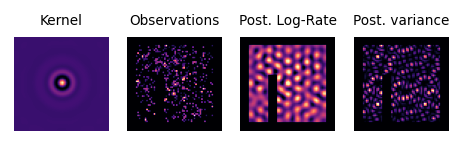

μ 41 0 ε=3.461177e-06 mintol=1.000000e-07 loss=-1.20370119595336309430e+04
X 41 0 ε=8.367059e-03 mintol=1.000000e-07 loss=-1.20370119563947937422e+04
Loss increasing, that's bad
X 41 1 ε=6.774151e-03 mintol=1.000000e-07 loss=-1.20370119695829653210e+04
X 41 2 ε=8.535559e-03 mintol=1.000000e-07 loss=-1.20370119452301478304e+04
Loss increasing, that's bad
X 41 3 ε=8.245899e-03 mintol=1.000000e-07 loss=-1.20370119378752060584e+04
Loss increasing, that's bad
X 41 4 ε=8.500621e-03 mintol=1.000000e-07 loss=-1.20370119604026149318e+04


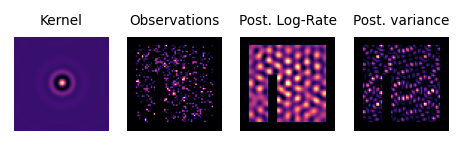

μ 42 0 ε=4.230929e-06 mintol=1.000000e-07 loss=-1.20370119604027549940e+04
X 42 0 ε=9.065135e-03 mintol=1.000000e-07 loss=-1.20370119352249021176e+04
Loss increasing, that's bad
X 42 1 ε=7.383622e-03 mintol=1.000000e-07 loss=-1.20370119299253728968e+04
Loss increasing, that's bad
X 42 2 ε=7.376506e-03 mintol=1.000000e-07 loss=-1.20370119099563289637e+04
Loss increasing, that's bad
X 42 3 ε=7.373519e-03 mintol=1.000000e-07 loss=-1.20370119252491331281e+04
X 42 4 ε=7.271916e-03 mintol=1.000000e-07 loss=-1.20370119057760166470e+04
Loss increasing, that's bad


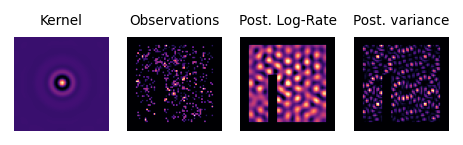

μ 43 0 ε=3.779352e-06 mintol=1.000000e-07 loss=-1.20370119057761257864e+04
X 43 0 ε=7.447275e-03 mintol=1.000000e-07 loss=-1.20370119255161753244e+04
X 43 1 ε=6.904981e-03 mintol=1.000000e-07 loss=-1.20370119269974129566e+04
X 43 2 ε=7.922865e-03 mintol=1.000000e-07 loss=-1.20370119060907618405e+04
Loss increasing, that's bad
X 43 3 ε=3.081933e-03 mintol=1.000000e-07 loss=-1.20370119142503699550e+04
X 43 4 ε=8.333724e-03 mintol=1.000000e-07 loss=-1.20370118961334846972e+04
Loss increasing, that's bad


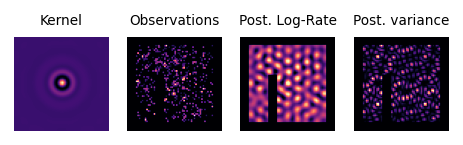

μ 44 0 ε=2.405698e-06 mintol=1.000000e-07 loss=-1.20370118961335265340e+04
X 44 0 ε=5.052791e-03 mintol=1.000000e-07 loss=-1.20370119092377499328e+04
X 44 1 ε=7.762761e-03 mintol=1.000000e-07 loss=-1.20370118978529553715e+04
Loss increasing, that's bad
X 44 2 ε=6.841045e-03 mintol=1.000000e-07 loss=-1.20370119140388305823e+04
X 44 3 ε=2.057421e-03 mintol=1.000000e-07 loss=-1.20370119088677711261e+04
Loss increasing, that's bad
X 44 4 ε=7.638752e-03 mintol=1.000000e-07 loss=-1.20370118931457709550e+04
Loss increasing, that's bad


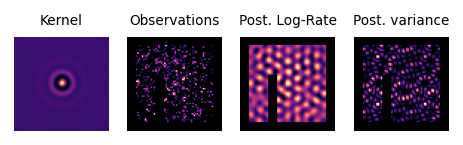

μ 45 0 ε=2.335557e-06 mintol=1.000000e-07 loss=-1.20370118931458146108e+04
X 45 0 ε=6.710278e-03 mintol=1.000000e-07 loss=-1.20370119093591983983e+04
X 45 1 ε=1.008994e-02 mintol=1.000000e-07 loss=-1.20370118839401638979e+04
Loss increasing, that's bad
X 45 2 ε=1.049926e-02 mintol=1.000000e-07 loss=-1.20370119076108803711e+04
X 45 3 ε=7.613876e-03 mintol=1.000000e-07 loss=-1.20370118887174885458e+04
Loss increasing, that's bad
X 45 4 ε=8.531700e-03 mintol=1.000000e-07 loss=-1.20370119098423801915e+04


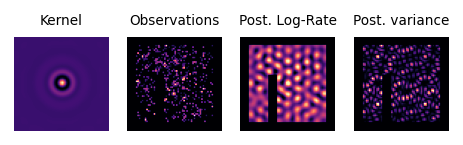

μ 46 0 ε=1.649212e-06 mintol=1.000000e-07 loss=-1.20370119098424129334e+04
X 46 0 ε=8.134381e-03 mintol=1.000000e-07 loss=-1.20370118898178061499e+04
Loss increasing, that's bad
X 46 1 ε=1.904561e-03 mintol=1.000000e-07 loss=-1.20370118942204608175e+04
X 46 2 ε=7.390358e-03 mintol=1.000000e-07 loss=-1.20370118781592154846e+04
Loss increasing, that's bad
X 46 3 ε=7.659877e-03 mintol=1.000000e-07 loss=-1.20370118968843416951e+04
X 46 4 ε=7.132546e-03 mintol=1.000000e-07 loss=-1.20370118800474483578e+04
Loss increasing, that's bad


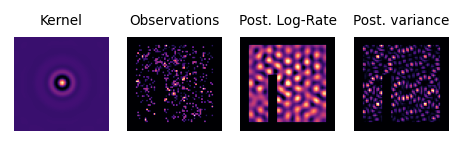

μ 47 0 ε=2.024754e-06 mintol=1.000000e-07 loss=-1.20370118800474829186e+04
X 47 0 ε=6.842849e-03 mintol=1.000000e-07 loss=-1.20370118852914565650e+04
X 47 1 ε=2.919478e-03 mintol=1.000000e-07 loss=-1.20370118921949560900e+04
X 47 2 ε=7.461182e-03 mintol=1.000000e-07 loss=-1.20370118764680264576e+04
Loss increasing, that's bad
X 47 3 ε=6.377075e-03 mintol=1.000000e-07 loss=-1.20370118901870737318e+04
X 47 4 ε=7.058726e-03 mintol=1.000000e-07 loss=-1.20370118736116928631e+04
Loss increasing, that's bad


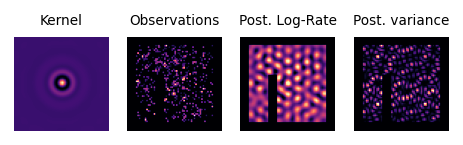

μ 48 0 ε=2.259787e-06 mintol=1.000000e-07 loss=-1.20370118736117346998e+04
X 48 0 ε=6.994782e-03 mintol=1.000000e-07 loss=-1.20370118789883472346e+04
X 48 1 ε=5.869624e-03 mintol=1.000000e-07 loss=-1.20370118919594769977e+04
X 48 2 ε=7.210975e-03 mintol=1.000000e-07 loss=-1.20370118754099166836e+04
Loss increasing, that's bad
X 48 3 ε=6.273837e-03 mintol=1.000000e-07 loss=-1.20370118740340330987e+04
Loss increasing, that's bad
X 48 4 ε=5.956112e-03 mintol=1.000000e-07 loss=-1.20370118871519207460e+04


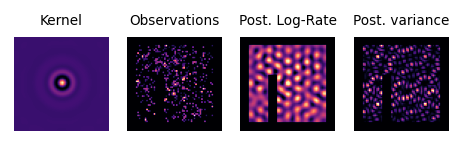

μ 49 0 ε=2.864861e-06 mintol=1.000000e-07 loss=-1.20370118871520007815e+04
X 49 0 ε=7.103127e-03 mintol=1.000000e-07 loss=-1.20370118711954983155e+04
Loss increasing, that's bad
X 49 1 ε=8.337047e-03 mintol=1.000000e-07 loss=-1.20370118733636645629e+04
X 49 2 ε=5.066334e-03 mintol=1.000000e-07 loss=-1.20370118778825799382e+04
X 49 3 ε=6.510725e-03 mintol=1.000000e-07 loss=-1.20370118637846971978e+04
Loss increasing, that's bad
X 49 4 ε=5.685634e-03 mintol=1.000000e-07 loss=-1.20370118717719597043e+04


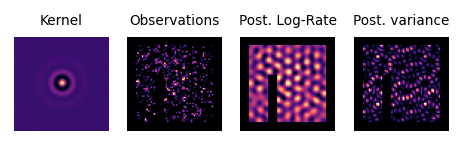

μ 50 0 ε=3.008661e-06 mintol=1.000000e-07 loss=-1.20370118717720397399e+04
X 50 0 ε=9.791809e-03 mintol=1.000000e-07 loss=-1.20370118691632942500e+04
Loss increasing, that's bad
X 50 1 ε=5.219706e-03 mintol=1.000000e-07 loss=-1.20370118746987955092e+04
X 50 2 ε=6.351707e-03 mintol=1.000000e-07 loss=-1.20370118615849969501e+04
Loss increasing, that's bad
X 50 3 ε=6.013350e-03 mintol=1.000000e-07 loss=-1.20370118501215983997e+04
Loss increasing, that's bad
X 50 4 ε=3.246553e-03 mintol=1.000000e-07 loss=-1.20370118566908404318e+04


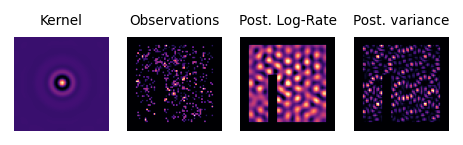

μ 51 0 ε=2.739044e-06 mintol=1.000000e-07 loss=-1.20370118566909077344e+04
X 51 0 ε=6.010314e-03 mintol=1.000000e-07 loss=-1.20370118480501769227e+04
Loss increasing, that's bad
X 51 1 ε=2.135796e-03 mintol=1.000000e-07 loss=-1.20370118521833228442e+04
X 51 2 ε=4.406713e-03 mintol=1.000000e-07 loss=-1.20370118610800454917e+04
X 51 3 ε=6.266998e-03 mintol=1.000000e-07 loss=-1.20370118484427803196e+04
Loss increasing, that's bad
X 51 4 ε=5.376068e-03 mintol=1.000000e-07 loss=-1.20370118508908708463e+04


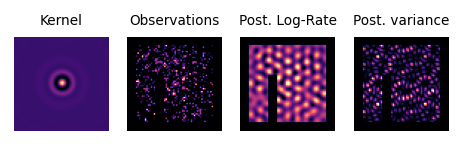

μ 52 0 ε=1.675709e-06 mintol=1.000000e-07 loss=-1.20370118508908981312e+04
X 52 0 ε=6.278799e-03 mintol=1.000000e-07 loss=-1.20370118534614066448e+04
X 52 1 ε=5.759412e-03 mintol=1.000000e-07 loss=-1.20370118421860006492e+04
Loss increasing, that's bad
X 52 2 ε=5.121857e-03 mintol=1.000000e-07 loss=-1.20370118521710428467e+04
X 52 3 ε=5.759585e-03 mintol=1.000000e-07 loss=-1.20370118580156886310e+04
X 52 4 ε=6.113780e-03 mintol=1.000000e-07 loss=-1.20370118461838083022e+04
Loss increasing, that's bad


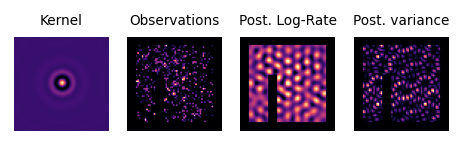

μ 53 0 ε=1.828149e-06 mintol=1.000000e-07 loss=-1.20370118461838428630e+04
X 53 0 ε=1.227517e-03 mintol=1.000000e-07 loss=-1.20370118485559651162e+04
X 53 1 ε=5.917903e-03 mintol=1.000000e-07 loss=-1.20370118570985705446e+04
X 53 2 ε=5.904561e-03 mintol=1.000000e-07 loss=-1.20370118459639052162e+04
Loss increasing, that's bad
X 53 3 ε=6.658183e-03 mintol=1.000000e-07 loss=-1.20370118586387379764e+04
X 53 4 ε=5.610058e-03 mintol=1.000000e-07 loss=-1.20370118490658023802e+04
Loss increasing, that's bad


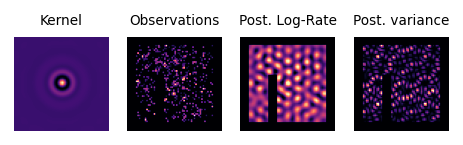

μ 54 0 ε=1.141062e-06 mintol=1.000000e-07 loss=-1.20370118490658151131e+04
X 54 0 ε=1.335149e-03 mintol=1.000000e-07 loss=-1.20370118515975464106e+04
X 54 1 ε=6.122895e-03 mintol=1.000000e-07 loss=-1.20370118400481169374e+04
Loss increasing, that's bad
X 54 2 ε=3.474618e-03 mintol=1.000000e-07 loss=-1.20370118466246058233e+04
X 54 3 ε=5.663547e-03 mintol=1.000000e-07 loss=-1.20370118432634553756e+04
Loss increasing, that's bad
X 54 4 ε=1.319598e-03 mintol=1.000000e-07 loss=-1.20370118455334140890e+04


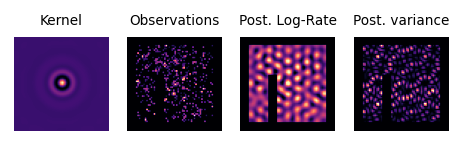

μ 55 0 ε=8.574917e-07 mintol=1.000000e-07 loss=-1.20370118455334231840e+04
X 55 0 ε=5.192503e-03 mintol=1.000000e-07 loss=-1.20370118490178374486e+04
X 55 1 ε=5.927314e-03 mintol=1.000000e-07 loss=-1.20370118382422642753e+04
Loss increasing, that's bad
X 55 2 ε=7.077038e-03 mintol=1.000000e-07 loss=-1.20370118511990367551e+04
X 55 3 ε=5.489438e-03 mintol=1.000000e-07 loss=-1.20370118418269139511e+04
Loss increasing, that's bad
X 55 4 ε=5.307664e-03 mintol=1.000000e-07 loss=-1.20370118453331633646e+04


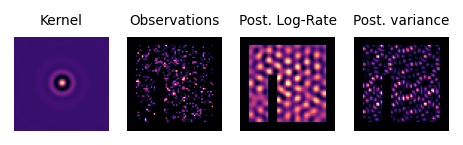

μ 56 0 ε=1.798199e-06 mintol=1.000000e-07 loss=-1.20370118453331997443e+04
X 56 0 ε=5.481743e-03 mintol=1.000000e-07 loss=-1.20370118354928144981e+04
Loss increasing, that's bad
X 56 1 ε=6.130600e-03 mintol=1.000000e-07 loss=-1.20370118464345396205e+04
X 56 2 ε=5.555178e-03 mintol=1.000000e-07 loss=-1.20370118365576563519e+04
Loss increasing, that's bad
X 56 3 ε=2.548329e-03 mintol=1.000000e-07 loss=-1.20370118410397190019e+04
X 56 4 ε=5.011136e-03 mintol=1.000000e-07 loss=-1.20370118353843645309e+04
Loss increasing, that's bad


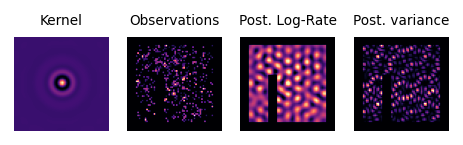

μ 57 0 ε=1.005977e-06 mintol=1.000000e-07 loss=-1.20370118353843736259e+04
X 57 0 ε=3.334301e-03 mintol=1.000000e-07 loss=-1.20370118412222927873e+04
X 57 1 ε=5.341764e-03 mintol=1.000000e-07 loss=-1.20370118320380679506e+04
Loss increasing, that's bad
X 57 2 ε=4.680534e-03 mintol=1.000000e-07 loss=-1.20370118401217769133e+04
X 57 3 ε=4.567337e-03 mintol=1.000000e-07 loss=-1.20370118326587435149e+04
Loss increasing, that's bad
X 57 4 ε=4.838895e-03 mintol=1.000000e-07 loss=-1.20370118401238469232e+04


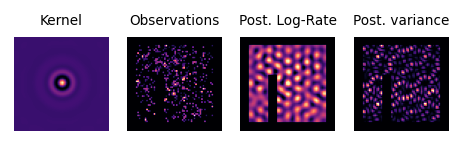

μ 58 0 ε=9.931195e-07 mintol=1.000000e-07 loss=-1.20370118401238596562e+04
X 58 0 ε=4.154448e-03 mintol=1.000000e-07 loss=-1.20370118422670566360e+04
X 58 1 ε=5.121676e-03 mintol=1.000000e-07 loss=-1.20370118335025945271e+04
Loss increasing, that's bad
X 58 2 ε=4.915282e-03 mintol=1.000000e-07 loss=-1.20370118346394883702e+04
X 58 3 ε=4.380620e-03 mintol=1.000000e-07 loss=-1.20370118416522855114e+04
X 58 4 ε=2.651473e-03 mintol=1.000000e-07 loss=-1.20370118372140404972e+04
Loss increasing, that's bad


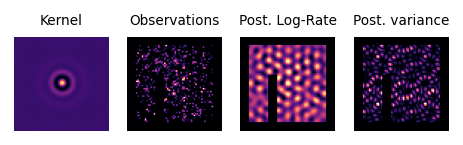

μ 59 0 ε=1.460118e-06 mintol=1.000000e-07 loss=-1.20370118372140677820e+04
X 59 0 ε=5.145678e-03 mintol=1.000000e-07 loss=-1.20370118291308244807e+04
Loss increasing, that's bad
X 59 1 ε=4.460790e-03 mintol=1.000000e-07 loss=-1.20370118361184941023e+04
X 59 2 ε=4.100328e-03 mintol=1.000000e-07 loss=-1.20370118387140119012e+04
X 59 3 ε=5.449933e-03 mintol=1.000000e-07 loss=-1.20370118297534245357e+04
Loss increasing, that's bad
X 59 4 ε=1.371753e-03 mintol=1.000000e-07 loss=-1.20370118320118108386e+04


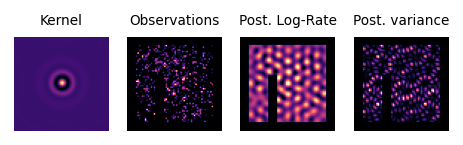

μ 60 0 ε=1.012581e-06 mintol=1.000000e-07 loss=-1.20370118320118235715e+04
X 60 0 ε=5.260779e-03 mintol=1.000000e-07 loss=-1.20370118389917042805e+04
X 60 1 ε=4.950775e-03 mintol=1.000000e-07 loss=-1.20370118309290191974e+04
Loss increasing, that's bad
X 60 2 ε=4.312833e-03 mintol=1.000000e-07 loss=-1.20370118360107917397e+04
X 60 3 ε=5.020546e-03 mintol=1.000000e-07 loss=-1.20370118279238886316e+04
Loss increasing, that's bad
X 60 4 ε=7.654909e-04 mintol=1.000000e-07 loss=-1.20370118291600028897e+04


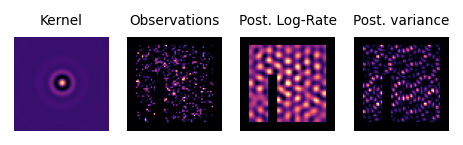

μ 61 0 ε=8.628732e-07 mintol=1.000000e-07 loss=-1.20370118291600101657e+04
X 61 0 ε=3.469242e-03 mintol=1.000000e-07 loss=-1.20370118347339721367e+04
X 61 1 ε=4.872527e-03 mintol=1.000000e-07 loss=-1.20370118322574326157e+04
Loss increasing, that's bad
X 61 2 ε=4.757655e-03 mintol=1.000000e-07 loss=-1.20370118247561003955e+04
Loss increasing, that's bad
X 61 3 ε=5.583811e-03 mintol=1.000000e-07 loss=-1.20370118336064188043e+04
X 61 4 ε=4.840580e-03 mintol=1.000000e-07 loss=-1.20370118260280996765e+04
Loss increasing, that's bad


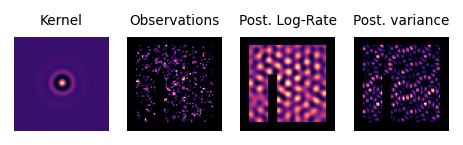

μ 62 0 ε=8.006362e-07 mintol=1.000000e-07 loss=-1.20370118260281087714e+04
X 62 0 ε=1.784749e-03 mintol=1.000000e-07 loss=-1.20370118288076173485e+04
X 62 1 ε=4.797156e-03 mintol=1.000000e-07 loss=-1.20370118234084657161e+04
Loss increasing, that's bad
X 62 2 ε=1.844377e-03 mintol=1.000000e-07 loss=-1.20370118262526575563e+04
X 62 3 ε=5.017624e-03 mintol=1.000000e-07 loss=-1.20370118289006222767e+04
X 62 4 ε=4.802357e-03 mintol=1.000000e-07 loss=-1.20370118215027068800e+04
Loss increasing, that's bad


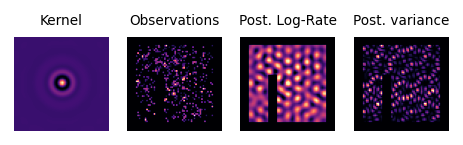

μ 63 0 ε=1.118755e-06 mintol=1.000000e-07 loss=-1.20370118215027250699e+04
X 63 0 ε=5.385760e-03 mintol=1.000000e-07 loss=-1.20370118297875687858e+04
X 63 1 ε=4.614737e-03 mintol=1.000000e-07 loss=-1.20370118338070114987e+04
X 63 2 ε=4.719097e-03 mintol=1.000000e-07 loss=-1.20370118266368226614e+04
Loss increasing, that's bad
X 63 3 ε=4.361251e-03 mintol=1.000000e-07 loss=-1.20370118253384262061e+04
Loss increasing, that's bad
X 63 4 ε=4.263856e-03 mintol=1.000000e-07 loss=-1.20370118190124449029e+04
Loss increasing, that's bad


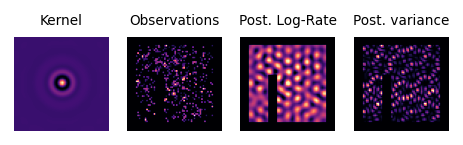

μ 64 0 ε=1.117863e-06 mintol=1.000000e-07 loss=-1.20370118190124612738e+04
X 64 0 ε=5.053075e-03 mintol=1.000000e-07 loss=-1.20370118265436121874e+04
X 64 1 ε=4.407272e-03 mintol=1.000000e-07 loss=-1.20370118199654971249e+04
Loss increasing, that's bad
X 64 2 ε=4.130876e-03 mintol=1.000000e-07 loss=-1.20370118228611863742e+04
X 64 3 ε=3.785959e-03 mintol=1.000000e-07 loss=-1.20370118236159069056e+04
X 64 4 ε=1.076286e-03 mintol=1.000000e-07 loss=-1.20370118249247589119e+04


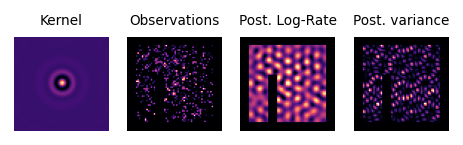

μ 65 0 ε=1.388901e-06 mintol=1.000000e-07 loss=-1.20370118249247825588e+04
X 65 0 ε=4.630499e-03 mintol=1.000000e-07 loss=-1.20370118181897250906e+04
Loss increasing, that's bad
X 65 1 ε=5.184388e-03 mintol=1.000000e-07 loss=-1.20370118226460417645e+04
X 65 2 ε=3.773511e-03 mintol=1.000000e-07 loss=-1.20370118253537639248e+04
X 65 3 ε=5.428671e-03 mintol=1.000000e-07 loss=-1.20370118176195046544e+04
Loss increasing, that's bad
X 65 4 ε=3.936439e-03 mintol=1.000000e-07 loss=-1.20370118204878417600e+04


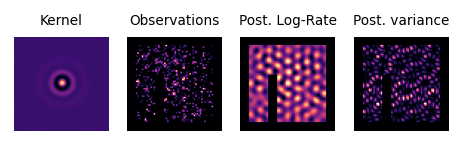

μ 66 0 ε=1.363383e-06 mintol=1.000000e-07 loss=-1.20370118204878726829e+04
X 66 0 ε=4.068143e-03 mintol=1.000000e-07 loss=-1.20370118147702269198e+04
Loss increasing, that's bad
X 66 1 ε=4.831744e-03 mintol=1.000000e-07 loss=-1.20370118215526781569e+04
X 66 2 ε=4.540958e-03 mintol=1.000000e-07 loss=-1.20370118151865772234e+04
Loss increasing, that's bad
X 66 3 ε=3.972514e-03 mintol=1.000000e-07 loss=-1.20370118184616640065e+04
X 66 4 ε=3.802633e-03 mintol=1.000000e-07 loss=-1.20370118131993676798e+04
Loss increasing, that's bad


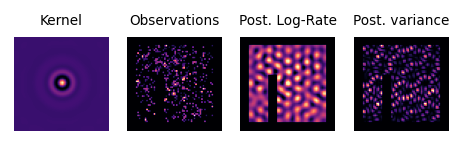

μ 67 0 ε=7.164716e-07 mintol=1.000000e-07 loss=-1.20370118131993749557e+04
X 67 0 ε=3.690692e-03 mintol=1.000000e-07 loss=-1.20370118167691707640e+04
X 67 1 ε=1.039020e-03 mintol=1.000000e-07 loss=-1.20370118181641282717e+04
X 67 2 ε=4.124207e-03 mintol=1.000000e-07 loss=-1.20370118129441052588e+04
Loss increasing, that's bad
X 67 3 ε=2.361394e-03 mintol=1.000000e-07 loss=-1.20370118161509999481e+04
X 67 4 ε=3.766735e-03 mintol=1.000000e-07 loss=-1.20370118170870191534e+04


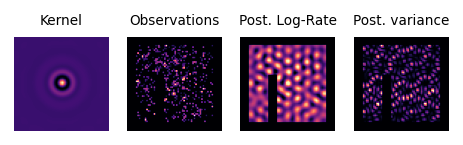

μ 68 0 ε=1.194838e-06 mintol=1.000000e-07 loss=-1.20370118170870373433e+04
X 68 0 ε=4.128103e-03 mintol=1.000000e-07 loss=-1.20370118115045479499e+04
Loss increasing, that's bad
X 68 1 ε=4.017601e-03 mintol=1.000000e-07 loss=-1.20370118168659446383e+04
X 68 2 ε=4.112063e-03 mintol=1.000000e-07 loss=-1.20370118113253338379e+04
Loss increasing, that's bad
X 68 3 ε=1.851253e-03 mintol=1.000000e-07 loss=-1.20370118138227771851e+04
X 68 4 ε=4.782058e-03 mintol=1.000000e-07 loss=-1.20370118116112680582e+04
Loss increasing, that's bad


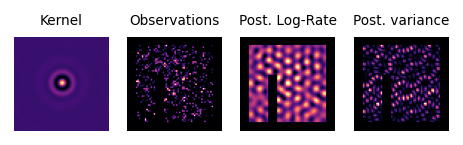

μ 69 0 ε=7.166472e-07 mintol=1.000000e-07 loss=-1.20370118116112753341e+04
X 69 0 ε=3.439328e-03 mintol=1.000000e-07 loss=-1.20370118160214024101e+04
X 69 1 ε=4.005830e-03 mintol=1.000000e-07 loss=-1.20370118107469315873e+04
Loss increasing, that's bad
X 69 2 ε=2.172022e-03 mintol=1.000000e-07 loss=-1.20370118135963512032e+04
X 69 3 ε=3.645421e-03 mintol=1.000000e-07 loss=-1.20370118093757209863e+04
Loss increasing, that's bad
X 69 4 ε=3.572118e-03 mintol=1.000000e-07 loss=-1.20370118140348840825e+04


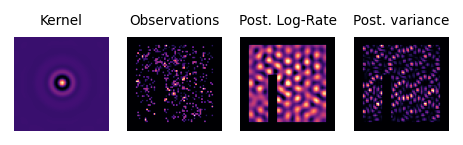

μ 70 0 ε=5.806149e-07 mintol=1.000000e-07 loss=-1.20370118140348895395e+04
X 70 0 ε=3.651398e-03 mintol=1.000000e-07 loss=-1.20370118093070013856e+04
Loss increasing, that's bad
X 70 1 ε=3.555776e-03 mintol=1.000000e-07 loss=-1.20370118135679640545e+04
X 70 2 ε=3.650254e-03 mintol=1.000000e-07 loss=-1.20370118088259096112e+04
Loss increasing, that's bad
X 70 3 ε=3.146448e-03 mintol=1.000000e-07 loss=-1.20370118129053371376e+04
X 70 4 ε=3.387355e-03 mintol=1.000000e-07 loss=-1.20370118138381076278e+04


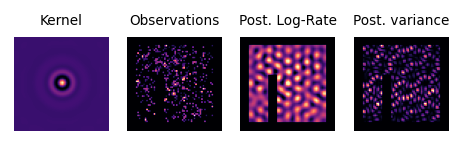

μ 71 0 ε=6.872036e-07 mintol=1.000000e-07 loss=-1.20370118138381149038e+04
X 71 0 ε=3.849411e-03 mintol=1.000000e-07 loss=-1.20370118088725030248e+04
Loss increasing, that's bad
X 71 1 ε=3.593596e-03 mintol=1.000000e-07 loss=-1.20370118092108550627e+04
X 71 2 ε=1.429224e-03 mintol=1.000000e-07 loss=-1.20370118109899467527e+04
X 71 3 ε=3.884702e-03 mintol=1.000000e-07 loss=-1.20370118062050714798e+04
Loss increasing, that's bad
X 71 4 ε=2.696632e-03 mintol=1.000000e-07 loss=-1.20370118096079786483e+04


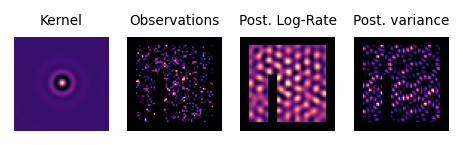

μ 72 0 ε=5.979819e-07 mintol=1.000000e-07 loss=-1.20370118096079841052e+04
X 72 0 ε=4.106285e-03 mintol=1.000000e-07 loss=-1.20370118083012748684e+04
Loss increasing, that's bad
X 72 1 ε=3.480595e-03 mintol=1.000000e-07 loss=-1.20370118039628541737e+04
Loss increasing, that's bad
X 72 2 ε=4.446497e-03 mintol=1.000000e-07 loss=-1.20370118095078396436e+04
X 72 3 ε=8.654788e-04 mintol=1.000000e-07 loss=-1.20370118105903311516e+04
X 72 4 ε=4.159931e-03 mintol=1.000000e-07 loss=-1.20370118054067625053e+04
Loss increasing, that's bad


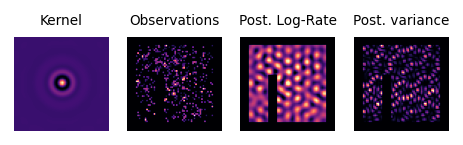

μ 73 0 ε=5.870127e-07 mintol=1.000000e-07 loss=-1.20370118054067697813e+04
X 73 0 ε=1.854598e-03 mintol=1.000000e-07 loss=-1.20370118077225215529e+04
X 73 1 ε=3.786262e-03 mintol=1.000000e-07 loss=-1.20370118086339789443e+04
X 73 2 ε=3.335160e-03 mintol=1.000000e-07 loss=-1.20370118116161775106e+04
X 73 3 ε=4.669335e-03 mintol=1.000000e-07 loss=-1.20370118058947427926e+04
Loss increasing, that's bad
X 73 4 ε=3.386148e-03 mintol=1.000000e-07 loss=-1.20370118095252983039e+04


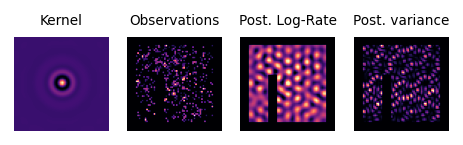

μ 74 0 ε=1.138676e-06 mintol=1.000000e-07 loss=-1.20370118095253183128e+04
X 74 0 ε=3.708352e-03 mintol=1.000000e-07 loss=-1.20370118050187302288e+04
Loss increasing, that's bad
X 74 1 ε=3.518724e-03 mintol=1.000000e-07 loss=-1.20370118092824723135e+04
X 74 2 ε=4.107716e-03 mintol=1.000000e-07 loss=-1.20370118042998474266e+04
Loss increasing, that's bad
X 74 3 ε=2.135986e-03 mintol=1.000000e-07 loss=-1.20370118068772826518e+04
X 74 4 ε=3.686900e-03 mintol=1.000000e-07 loss=-1.20370118024200273794e+04
Loss increasing, that's bad


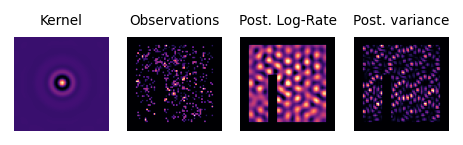

μ 75 0 ε=7.546555e-07 mintol=1.000000e-07 loss=-1.20370118024200310174e+04
X 75 0 ε=3.293901e-03 mintol=1.000000e-07 loss=-1.20370118063991540112e+04
X 75 1 ε=3.643932e-03 mintol=1.000000e-07 loss=-1.20370118023189079395e+04
Loss increasing, that's bad
X 75 2 ε=3.199735e-03 mintol=1.000000e-07 loss=-1.20370118051599238242e+04
X 75 3 ε=3.485589e-03 mintol=1.000000e-07 loss=-1.20370118063088411873e+04
X 75 4 ε=2.842132e-03 mintol=1.000000e-07 loss=-1.20370118068722040334e+04


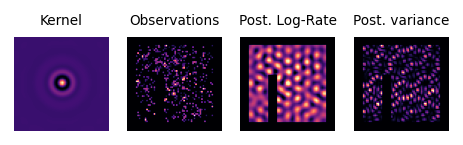

μ 76 0 ε=1.387785e-06 mintol=1.000000e-07 loss=-1.20370118068722349562e+04
X 76 0 ε=3.692145e-03 mintol=1.000000e-07 loss=-1.20370118025469600980e+04
Loss increasing, that's bad
X 76 1 ε=3.132203e-03 mintol=1.000000e-07 loss=-1.20370118053253045218e+04
X 76 2 ε=3.786683e-03 mintol=1.000000e-07 loss=-1.20370118009169600555e+04
Loss increasing, that's bad
X 76 3 ε=3.904067e-03 mintol=1.000000e-07 loss=-1.20370118054347422003e+04
X 76 4 ε=3.700931e-03 mintol=1.000000e-07 loss=-1.20370118011429749458e+04
Loss increasing, that's bad


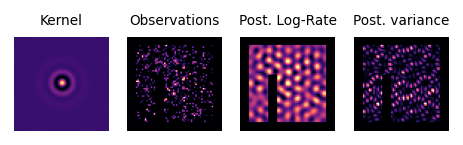

μ 77 0 ε=6.615394e-07 mintol=1.000000e-07 loss=-1.20370118011429804028e+04
X 77 0 ε=3.224498e-03 mintol=1.000000e-07 loss=-1.20370117995805649116e+04
Loss increasing, that's bad
X 77 1 ε=3.146577e-03 mintol=1.000000e-07 loss=-1.20370118030194735184e+04
X 77 2 ε=1.803741e-03 mintol=1.000000e-07 loss=-1.20370118009567813715e+04
Loss increasing, that's bad
X 77 3 ε=3.129987e-03 mintol=1.000000e-07 loss=-1.20370118033063590701e+04
X 77 4 ε=3.878410e-03 mintol=1.000000e-07 loss=-1.20370117989037262305e+04
Loss increasing, that's bad


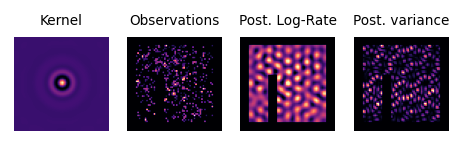

μ 78 0 ε=7.760297e-07 mintol=1.000000e-07 loss=-1.20370117989037353254e+04
X 78 0 ε=3.149790e-03 mintol=1.000000e-07 loss=-1.20370118022230562929e+04
X 78 1 ε=3.697799e-03 mintol=1.000000e-07 loss=-1.20370117980585491750e+04
Loss increasing, that's bad
X 78 2 ε=8.107041e-04 mintol=1.000000e-07 loss=-1.20370117989742811915e+04
X 78 3 ε=3.297241e-03 mintol=1.000000e-07 loss=-1.20370118004641317384e+04
X 78 4 ε=3.404491e-03 mintol=1.000000e-07 loss=-1.20370117966862235335e+04
Loss increasing, that's bad


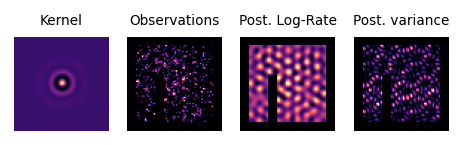

μ 79 0 ε=5.502734e-07 mintol=1.000000e-07 loss=-1.20370117966862271714e+04
X 79 0 ε=4.382738e-03 mintol=1.000000e-07 loss=-1.20370118015601801744e+04
X 79 1 ε=3.498817e-03 mintol=1.000000e-07 loss=-1.20370117976642031863e+04
Loss increasing, that's bad
X 79 2 ε=1.161095e-03 mintol=1.000000e-07 loss=-1.20370117989583523013e+04
X 79 3 ε=3.457690e-03 mintol=1.000000e-07 loss=-1.20370117951585689298e+04
Loss increasing, that's bad
X 79 4 ε=3.134379e-03 mintol=1.000000e-07 loss=-1.20370117986371315055e+04


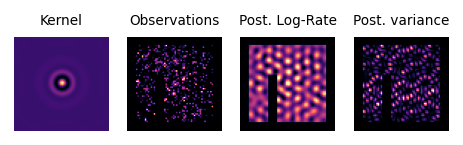

μ 80 0 ε=3.084075e-07 mintol=1.000000e-07 loss=-1.20370117986371333245e+04
X 80 0 ε=3.265008e-03 mintol=1.000000e-07 loss=-1.20370117951755310060e+04
Loss increasing, that's bad
X 80 1 ε=2.416098e-03 mintol=1.000000e-07 loss=-1.20370117978439720900e+04
X 80 2 ε=9.974725e-05 mintol=1.000000e-07 loss=-1.20370117979544356785e+04
X 80 3 ε=3.397920e-03 mintol=1.000000e-07 loss=-1.20370117946409463912e+04
Loss increasing, that's bad
X 80 4 ε=2.391367e-03 mintol=1.000000e-07 loss=-1.20370117972664720583e+04


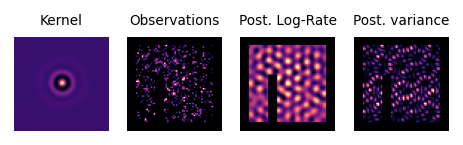

μ 81 0 ε=3.522371e-07 mintol=1.000000e-07 loss=-1.20370117972664738772e+04
X 81 0 ε=8.319617e-06 mintol=1.000000e-07 loss=-1.20370117972756324889e+04
X 81 1 ε=3.402178e-03 mintol=1.000000e-07 loss=-1.20370117946398440836e+04
Loss increasing, that's bad
X 81 2 ε=8.527231e-04 mintol=1.000000e-07 loss=-1.20370117955504938436e+04
X 81 3 ε=3.011686e-03 mintol=1.000000e-07 loss=-1.20370117983168966020e+04
X 81 4 ε=4.406675e-03 mintol=1.000000e-07 loss=-1.20370117935280431993e+04
Loss increasing, that's bad


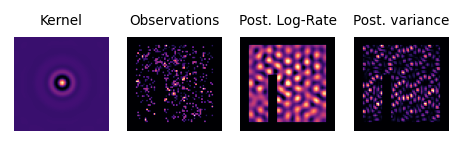

μ 82 0 ε=6.463724e-07 mintol=1.000000e-07 loss=-1.20370117935280486563e+04
X 82 0 ε=2.937998e-03 mintol=1.000000e-07 loss=-1.20370117966533052822e+04
X 82 1 ε=3.139490e-03 mintol=1.000000e-07 loss=-1.20370117932703305996e+04
Loss increasing, that's bad
X 82 2 ε=3.014412e-03 mintol=1.000000e-07 loss=-1.20370117960180014052e+04
X 82 3 ε=3.120911e-03 mintol=1.000000e-07 loss=-1.20370117982461797510e+04
X 82 4 ε=3.409276e-03 mintol=1.000000e-07 loss=-1.20370117946121445129e+04
Loss increasing, that's bad


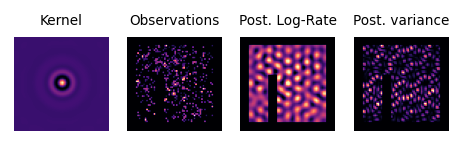

μ 83 0 ε=6.532352e-07 mintol=1.000000e-07 loss=-1.20370117946121517889e+04
X 83 0 ε=4.973957e-04 mintol=1.000000e-07 loss=-1.20370117951424072089e+04
X 83 1 ε=3.358338e-03 mintol=1.000000e-07 loss=-1.20370117915731079847e+04
Loss increasing, that's bad
X 83 2 ε=2.807658e-03 mintol=1.000000e-07 loss=-1.20370117939746869524e+04
X 83 3 ε=2.899790e-03 mintol=1.000000e-07 loss=-1.20370117909144282748e+04
Loss increasing, that's bad
X 83 4 ε=2.890302e-03 mintol=1.000000e-07 loss=-1.20370117939530500735e+04


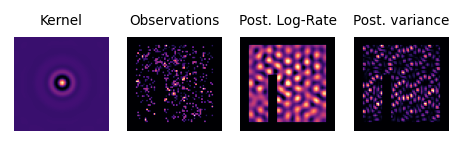

μ 84 0 ε=2.973188e-07 mintol=1.000000e-07 loss=-1.20370117939530537114e+04
X 84 0 ε=3.177036e-03 mintol=1.000000e-07 loss=-1.20370117934843929106e+04
Loss increasing, that's bad
X 84 1 ε=3.060988e-03 mintol=1.000000e-07 loss=-1.20370117902878537279e+04
Loss increasing, that's bad
X 84 2 ε=5.803020e-03 mintol=1.000000e-07 loss=-1.20370117900283730705e+04
Loss increasing, that's bad
X 84 3 ε=1.083366e-03 mintol=1.000000e-07 loss=-1.20370117911074903532e+04
X 84 4 ε=3.184767e-03 mintol=1.000000e-07 loss=-1.20370117879234767315e+04
Loss increasing, that's bad


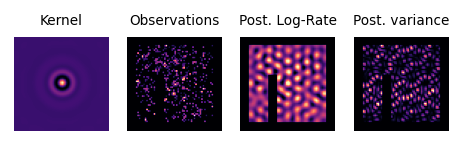

μ 85 0 ε=1.400229e-06 mintol=1.000000e-07 loss=-1.20370117879234985594e+04
X 85 0 ε=2.039615e-03 mintol=1.000000e-07 loss=-1.20370117899952765583e+04
X 85 1 ε=3.011142e-03 mintol=1.000000e-07 loss=-1.20370117916272592993e+04
X 85 2 ε=4.520265e-03 mintol=1.000000e-07 loss=-1.20370117870547146595e+04
Loss increasing, that's bad
X 85 3 ε=2.754356e-03 mintol=1.000000e-07 loss=-1.20370117897985401214e+04
X 85 4 ε=2.830401e-03 mintol=1.000000e-07 loss=-1.20370117869727655489e+04
Loss increasing, that's bad


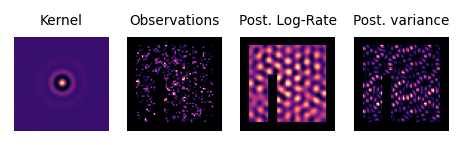

μ 86 0 ε=4.510890e-07 mintol=1.000000e-07 loss=-1.20370117869727691868e+04
X 86 0 ε=3.004117e-03 mintol=1.000000e-07 loss=-1.20370117898867574695e+04
X 86 1 ε=3.056963e-03 mintol=1.000000e-07 loss=-1.20370117868245797581e+04
Loss increasing, that's bad
X 86 2 ε=2.634853e-03 mintol=1.000000e-07 loss=-1.20370117887291944498e+04
X 86 3 ε=2.936851e-03 mintol=1.000000e-07 loss=-1.20370117858023022563e+04
Loss increasing, that's bad
X 86 4 ε=1.005361e-03 mintol=1.000000e-07 loss=-1.20370117868025608914e+04


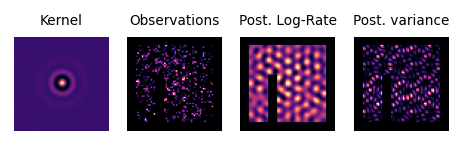

μ 87 0 ε=3.793049e-07 mintol=1.000000e-07 loss=-1.20370117868025627104e+04
X 87 0 ε=3.197961e-03 mintol=1.000000e-07 loss=-1.20370117878668770572e+04
X 87 1 ε=3.091527e-03 mintol=1.000000e-07 loss=-1.20370117848271565890e+04
Loss increasing, that's bad
X 87 2 ε=6.402881e-04 mintol=1.000000e-07 loss=-1.20370117854570544296e+04
X 87 3 ε=3.462157e-03 mintol=1.000000e-07 loss=-1.20370117886871739756e+04
X 87 4 ε=3.072463e-03 mintol=1.000000e-07 loss=-1.20370117856800570735e+04
Loss increasing, that's bad


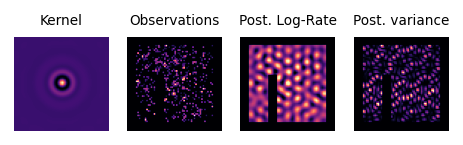

μ 88 0 ε=5.771357e-07 mintol=1.000000e-07 loss=-1.20370117856800607115e+04
X 88 0 ε=2.974056e-03 mintol=1.000000e-07 loss=-1.20370117883805596648e+04
X 88 1 ε=2.963953e-03 mintol=1.000000e-07 loss=-1.20370117854924865242e+04
Loss increasing, that's bad
X 88 2 ε=2.528627e-03 mintol=1.000000e-07 loss=-1.20370117856657980155e+04
X 88 3 ε=3.096443e-03 mintol=1.000000e-07 loss=-1.20370117826774385321e+04
Loss increasing, that's bad
X 88 4 ε=3.016684e-03 mintol=1.000000e-07 loss=-1.20370117832609121251e+04


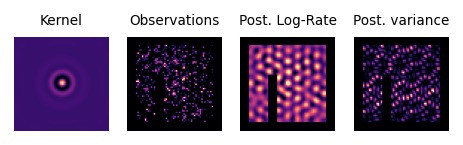

μ 89 0 ε=9.492704e-07 mintol=1.000000e-07 loss=-1.20370117832609212201e+04
X 89 0 ε=2.712276e-03 mintol=1.000000e-07 loss=-1.20370117806836660748e+04
Loss increasing, that's bad
X 89 1 ε=3.389539e-03 mintol=1.000000e-07 loss=-1.20370117839021277177e+04
X 89 2 ε=2.723363e-03 mintol=1.000000e-07 loss=-1.20370117813115830359e+04
Loss increasing, that's bad
X 89 3 ε=2.587996e-03 mintol=1.000000e-07 loss=-1.20370117828574911982e+04
X 89 4 ε=5.283303e-04 mintol=1.000000e-07 loss=-1.20370117833327676635e+04


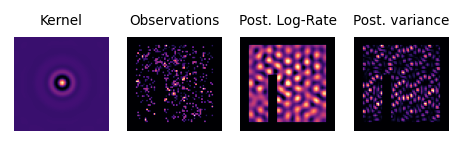

μ 90 0 ε=3.453532e-07 mintol=1.000000e-07 loss=-1.20370117833327694825e+04
X 90 0 ε=8.730856e-04 mintol=1.000000e-07 loss=-1.20370117825154284219e+04
Loss increasing, that's bad
X 90 1 ε=2.948205e-03 mintol=1.000000e-07 loss=-1.20370117808042086835e+04
Loss increasing, that's bad
X 90 2 ε=8.433387e-04 mintol=1.000000e-07 loss=-1.20370117815732592135e+04
X 90 3 ε=2.989371e-03 mintol=1.000000e-07 loss=-1.20370117788914685661e+04
Loss increasing, that's bad
X 90 4 ε=2.589708e-03 mintol=1.000000e-07 loss=-1.20370117812869357294e+04


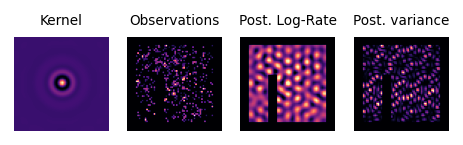

μ 91 0 ε=5.612919e-07 mintol=1.000000e-07 loss=-1.20370117812869411864e+04
X 91 0 ε=2.655770e-03 mintol=1.000000e-07 loss=-1.20370117788431234658e+04
Loss increasing, that's bad
X 91 1 ε=2.529189e-03 mintol=1.000000e-07 loss=-1.20370117787877970841e+04
Loss increasing, that's bad
X 91 2 ε=1.114368e-03 mintol=1.000000e-07 loss=-1.20370117798161572864e+04
X 91 3 ε=2.239730e-03 mintol=1.000000e-07 loss=-1.20370117792152141192e+04
Loss increasing, that's bad
X 91 4 ε=2.749379e-03 mintol=1.000000e-07 loss=-1.20370117767147003178e+04
Loss increasing, that's bad


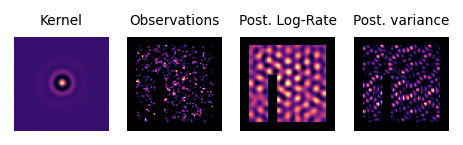

μ 92 0 ε=9.347287e-07 mintol=1.000000e-07 loss=-1.20370117767147075938e+04
X 92 0 ε=1.151593e-03 mintol=1.000000e-07 loss=-1.20370117777670238866e+04
X 92 1 ε=2.624751e-03 mintol=1.000000e-07 loss=-1.20370117795203659625e+04
X 92 2 ε=2.712579e-03 mintol=1.000000e-07 loss=-1.20370117770607412240e+04
Loss increasing, that's bad
X 92 3 ε=2.507298e-03 mintol=1.000000e-07 loss=-1.20370117791008433414e+04
X 92 4 ε=2.788184e-03 mintol=1.000000e-07 loss=-1.20370117765900904487e+04
Loss increasing, that's bad


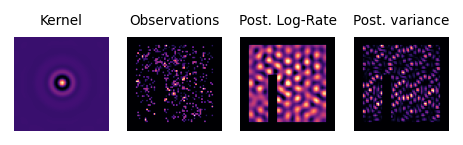

μ 93 0 ε=4.299226e-07 mintol=1.000000e-07 loss=-1.20370117765900922677e+04
X 93 0 ε=3.081386e-03 mintol=1.000000e-07 loss=-1.20370117793689296377e+04
X 93 1 ε=4.067114e-03 mintol=1.000000e-07 loss=-1.20370117757003499719e+04
Loss increasing, that's bad
X 93 2 ε=3.099618e-03 mintol=1.000000e-07 loss=-1.20370117784880312684e+04
X 93 3 ε=2.875087e-03 mintol=1.000000e-07 loss=-1.20370117758992619201e+04
Loss increasing, that's bad
X 93 4 ε=2.662256e-03 mintol=1.000000e-07 loss=-1.20370117752192545595e+04
Loss increasing, that's bad


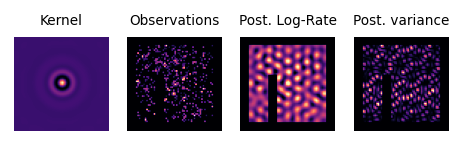

μ 94 0 ε=4.729914e-07 mintol=1.000000e-07 loss=-1.20370117752192545595e+04
X 94 0 ε=2.241710e-03 mintol=1.000000e-07 loss=-1.20370117770558408665e+04
X 94 1 ε=2.874947e-03 mintol=1.000000e-07 loss=-1.20370117745014686079e+04
Loss increasing, that's bad
X 94 2 ε=6.849809e-04 mintol=1.000000e-07 loss=-1.20370117750675672141e+04
X 94 3 ε=2.285122e-03 mintol=1.000000e-07 loss=-1.20370117754338843952e+04
X 94 4 ε=2.834140e-03 mintol=1.000000e-07 loss=-1.20370117729437461094e+04
Loss increasing, that's bad


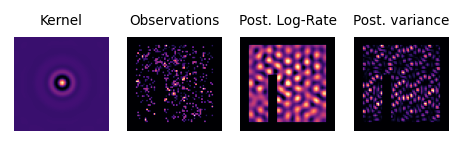

μ 95 0 ε=6.010108e-07 mintol=1.000000e-07 loss=-1.20370117729437497474e+04
X 95 0 ε=1.601350e-03 mintol=1.000000e-07 loss=-1.20370117741804151592e+04
X 95 1 ε=2.227500e-03 mintol=1.000000e-07 loss=-1.20370117738884055143e+04
Loss increasing, that's bad
X 95 2 ε=2.624665e-03 mintol=1.000000e-07 loss=-1.20370117716110453330e+04
Loss increasing, that's bad
X 95 3 ε=7.747703e-04 mintol=1.000000e-07 loss=-1.20370117722842660442e+04
X 95 4 ε=2.559523e-03 mintol=1.000000e-07 loss=-1.20370117736913380213e+04


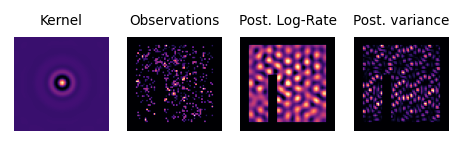

μ 96 0 ε=7.328512e-07 mintol=1.000000e-07 loss=-1.20370117736913452973e+04
X 96 0 ε=2.743646e-03 mintol=1.000000e-07 loss=-1.20370117713274139533e+04
Loss increasing, that's bad
X 96 1 ε=4.624473e-04 mintol=1.000000e-07 loss=-1.20370117717260800418e+04
X 96 2 ε=6.927657e-04 mintol=1.000000e-07 loss=-1.20370117723163220944e+04
X 96 3 ε=2.259260e-03 mintol=1.000000e-07 loss=-1.20370117733357819816e+04
X 96 4 ε=2.902489e-03 mintol=1.000000e-07 loss=-1.20370117708455927641e+04
Loss increasing, that's bad


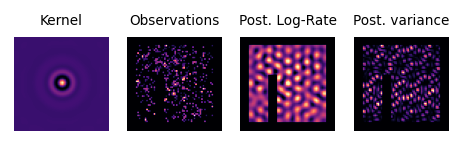

μ 97 0 ε=5.358578e-07 mintol=1.000000e-07 loss=-1.20370117708455964021e+04
X 97 0 ε=3.195803e-03 mintol=1.000000e-07 loss=-1.20370117735537187400e+04
X 97 1 ε=3.971592e-03 mintol=1.000000e-07 loss=-1.20370117701657709404e+04
Loss increasing, that's bad
X 97 2 ε=5.854367e-04 mintol=1.000000e-07 loss=-1.20370117706495584571e+04
X 97 3 ε=2.394640e-03 mintol=1.000000e-07 loss=-1.20370117706986329722e+04
X 97 4 ε=1.132287e-03 mintol=1.000000e-07 loss=-1.20370117697564237460e+04
Loss increasing, that's bad


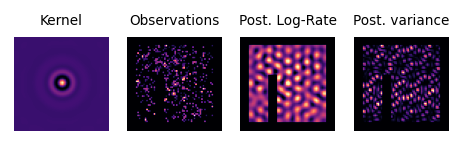

μ 98 0 ε=4.738215e-07 mintol=1.000000e-07 loss=-1.20370117697564273840e+04
X 98 0 ε=2.190241e-03 mintol=1.000000e-07 loss=-1.20370117697465975652e+04
Loss increasing, that's bad
X 98 1 ε=2.550131e-03 mintol=1.000000e-07 loss=-1.20370117676096997457e+04
Loss increasing, that's bad
X 98 2 ε=2.836070e-03 mintol=1.000000e-07 loss=-1.20370117699516285938e+04
X 98 3 ε=2.629534e-03 mintol=1.000000e-07 loss=-1.20370117677574362460e+04
Loss increasing, that's bad
X 98 4 ε=4.636461e-04 mintol=1.000000e-07 loss=-1.20370117681445244671e+04


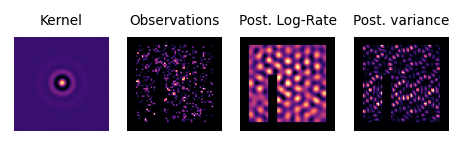

μ 99 0 ε=4.809646e-07 mintol=1.000000e-07 loss=-1.20370117681445262861e+04
X 99 0 ε=2.611420e-03 mintol=1.000000e-07 loss=-1.20370117690598835907e+04
X 99 1 ε=2.494732e-03 mintol=1.000000e-07 loss=-1.20370117670013714815e+04
Loss increasing, that's bad
X 99 2 ε=2.386099e-03 mintol=1.000000e-07 loss=-1.20370117688984410051e+04
X 99 3 ε=1.421631e-03 mintol=1.000000e-07 loss=-1.20370117677301641379e+04
Loss increasing, that's bad
X 99 4 ε=1.152451e-03 mintol=1.000000e-07 loss=-1.20370117667822596559e+04
Loss increasing, that's bad


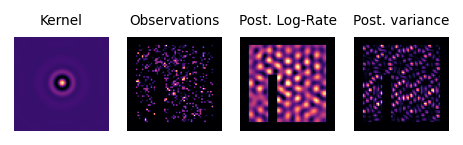

Δt = 610162 mselapsed for elapsed


In [98]:
# Rank of covariance matrix 
R = 1

# Precompute variables; Passed as globals to jac/hess
kern = kern0*zerolag(radial_acorr(lλf,mask))
kern = repair_small_eigenvalues(kern,1e-4)
knft = np0.array(real(fft2(kern)))
knft[0,0] += 1e2
Λ0ft = 1.0/knft

Kf      = knft
Λf      = Λ0ft
M       = cop(Kf)
Λ0      = cop(Λf)
lndΣ0   = sum(log(Kf))

def loss(μ,X):
    λ = exp(μ+μ0+sum(X**2,1)/2)
    ε = λ - y*μ
    trΛ0Σ = sum(X*conm(Λf,X))
    μΛ0μ  = μ.T @ conv(Λf,μ)
    lndΣ  = logdet(X.T@X)
    return n@ε + μΛ0μ/2 + trΛ0Σ/2 + lndΣ0/2 - lndΣ/2

tic('elapsed')

X  = randn(L*L,R)/L**2
X  = conm(Kf,X).reshape(L*L,R)
μ  = lλf.ravel()
μ0 = lλb.ravel()
mintol,ε,εs,l = 1e-4, inf, [], inf
print( 'loss=%e'%loss(μ,X) )
for iteration in range(100):
    
    for i in range(100):
        λ  = sexp(μ+μ0+sum(X**2,1)/2)
        Jμ = n*(λ-y) + conv(Λf,μ) 
        Hμ = Λ0 + diagop(n*λ)
        Δμ = -minres(Hμ,Jμ,tol=mintol,M=M)[0]
        μ += Δμ
        εμ = np.mean(abs(Δμ)/abs(μ))
        ε = εμ
        oldl = l
        l = loss(μ,X)
        print('μ',iteration,i,'ε=%e'%ε,'mintol=%e'%mintol,'loss=%.20e'%l)
        if oldl<l:
            print('Loss increasing, that\'s bad')
            mintol = maximum(1e-7,mintol/10)
            #break
        if ε<εv/100: break
    
    for i in range(5):
        nλ = n*sexp(μ+μ0+sum(X**2,1)/2)
        P  = pinv(X)
        JX = nλ[:,None]*X + conm(Λf,X) - P.T
        def preconditioner(A):
            A = A.reshape(L*L,R)
            return conm(Λf,A).ravel()
        preconditioner = op(L*L*R,preconditioner)
        def hvp(M):
            M    = M.reshape(L*L,R)
            xm   = sum(X*M,1)
            P    = pinv(X)
            Pt   = P.T
            PPt  = P@Pt
            #dpnv = Pt@(M.T@Pt+(X.T@M)@PPt) - M@PPt
            dpnv = contract('ji,kj,lk->il',P,M,P)+\
                contract('ji,kj,km,mn,ln->il',P,X,M,P,P)-\
                contract('ij,jk,lk->il',M,P,P)
            return (nλ[:,None]*(M + xm[:,None]*X) + conm(Λf,M) + dpnv).ravel()
        HX = op(L*L*R,hvp)
        ΔX = -minres(HX,JX.ravel(),tol=mintol,M=preconditioner)[0]
        ΔX = ΔX.reshape(X.shape)
        X += ΔX
        εv = np.mean(abs(ΔX))/mean(abs(X))
        ε  = εv
        oldl = l
        l = loss(μ,X)
        print('X',iteration,i,'ε=%e'%ε,'mintol=%e'%mintol,'loss=%.20e'%l)
        if oldl<l:
            print('Loss increasing, that\'s bad')
            mintol = maximum(1e-7,mintol/10)
            #break
        if ε<εv/100: break
            
    figure(figsize=(4,1.5))
    subplot(141); showkn(kern,'Kernel');
    subplot(142); showim(np0.array(y),'Observations');
    subplot(143); showim(μ,'Post. Log-Rate',mask=mask);
    subplot(144); showim(sum(X**2,1),'Post. variance',mask=mask);
    show()

tic('elapsed')

μ_=μ
X_=X

In [92]:
# Rank of covariance matrix 
R = 5

# Precompute variables; Passed as globals to jac/hess
kern = kern0*zerolag(radial_acorr(lλf,mask))
kern = repair_small_eigenvalues(kern,1e-5)
knft = np0.array(real(fft2(kern)))
knft[0,0] += 1e6
Λ0ft = 1.0/knft

Kf      = knft
Λf      = Λ0ft
M       = cop(Kf)
Λ0      = cop(Λf)
lndΣ0   = sum(log(Kf))

def loss(μ,X):
    λ = exp(μ+μ0)*(1+sum(X**2,1)/2)
    ε = λ - y*μ
    trΛ0Σ = sum(X*conm(Λf,X))
    μΛ0μ  = μ.T @ conv(Λf,μ)
    lndΣ  = logdet(X.T@X)
    return n@ε + μΛ0μ/2 + trΛ0Σ/2 + lndΣ0/2 - lndΣ/2

tic('elapsed')

X  = randn(L*L,R)/L**2
μ  = lλf.ravel()
μ0 = lλb.ravel()
mintol,ε,εs,l = 1e-2, inf, [], inf
print( 'loss=%e'%loss(μ,X) )
for iteration in range(100):
    
    for i in range(5):
        λ  = sexp(μ+μ0)*(1+sum(X**2,1)/2)
        Jμ = n*(λ-y) + conv(Λf,μ) 
        Hμ = Λ0 + diagop(n*λ)
        Δμ = -minres(Hμ,Jμ,tol=mintol,M=M)[0]
        μ += Δμ
        
    εμ = np.mean(abs(Δμ)/abs(μ))
    
    for i in range(5):
        nλ  = n*sexp(μ+μ0)
        P   = pinv(X)
        JX  = nλ[:,None]*X + conm(Λf,X) - P.T
        P   = pinv(X)
        Pt  = P.T
        PPt = P@Pt
        def hvp(M):
            M    = M.reshape(L*L,R)
            dpnv = Pt@(M.T@Pt+(X.T@M)@PPt) - M@PPt
            return nλ[:,None]*M + conm(Λf,M) + dpnv
        HX = op(L*L*R,hvp)
        ΔX = -minres(HX,JX.ravel(),tol=mintol)[0].reshape(X.shape)
        X += ΔX

    εv = np.mean(abs(ΔX))/mean(abs(X))
    
    oldε = ε
    ε = mean(array([εμ,εv]))
    εs.append(ε)
    oldl = l
    l = loss(μ,X)
    print('iteration',iteration,'ε=%e'%ε,'mintol=%e'%mintol,'loss=%e'%l)
    if oldl<l:
        print('Loss increasing, that\'s bad')
        mintol *= 0.5
    if ε<1e-5:
        print('Converged')
        break
    if ε>oldε:
        mintol *= 0.5
tic('elapsed')
        
subplot(141); showkn(kern,'Kernel');
subplot(142); showim(np0.array(y),'Observations');
subplot(143); showim(μ,'Post. Log-Rate',mask=mask);
subplot(144); showim(sum(X**2,1),'Post. variance',mask=mask);

μ_=μ
X_=X

Δt = 6871 ms  elapsed for elapsed
loss=2.588384e+06
iteration 0 ε=5.466028e-01 mintol=1.000000e-02 loss=-1.551641e+04
iteration 1 ε=4.129498e-02 mintol=1.000000e-02 loss=-1.551938e+04
iteration 2 ε=4.773900e-02 mintol=1.000000e-02 loss=-1.551921e+04
Loss increasing, that's bad
iteration 3 ε=1.422113e-02 mintol=2.500000e-03 loss=-1.551919e+04
Loss increasing, that's bad
iteration 4 ε=5.297368e-02 mintol=1.250000e-03 loss=-1.551918e+04
Loss increasing, that's bad
iteration 5 ε=3.328609e-02 mintol=3.125000e-04 loss=-1.551920e+04
iteration 6 ε=1.194006e-02 mintol=3.125000e-04 loss=-1.551921e+04


KeyboardInterrupt: 

# Using Jax 

loss=5.734848e+03
iteration 0 ε=2.526352e-01 mintol=1.000000e-02 loss=2.406735e+01
iteration 1 ε=1.958203e-01 mintol=1.000000e-02 loss=-1.581011e-01
iteration 2 ε=5.118231e-01 mintol=1.000000e-02 loss=2.342833e+01
Loss increasing, that's bad
iteration 3 ε=2.841081e-01 mintol=2.500000e-03 loss=-9.308460e-01
iteration 4 ε=1.157155e-01 mintol=2.500000e-03 loss=-1.474552e+00
iteration 5 ε=2.431301e-02 mintol=2.500000e-03 loss=-1.574152e+00
iteration 6 ε=8.048238e-01 mintol=2.500000e-03 loss=-1.676581e+00
iteration 7 ε=6.816361e-02 mintol=1.250000e-03 loss=-1.704880e+00
iteration 8 ε=1.698739e-01 mintol=1.250000e-03 loss=-1.716098e+00
iteration 9 ε=2.736128e-01 mintol=6.250000e-04 loss=-1.719581e+00
iteration 10 ε=1.601118e-02 mintol=3.125000e-04 loss=-1.721557e+00
iteration 11 ε=9.470834e-03 mintol=3.125000e-04 loss=-1.721878e+00
iteration 12 ε=4.025106e-03 mintol=3.125000e-04 loss=-1.721956e+00
iteration 13 ε=2.760148e-03 mintol=3.125000e-04 loss=-1.721996e+00
iteration 14 ε=1.444751e-03 

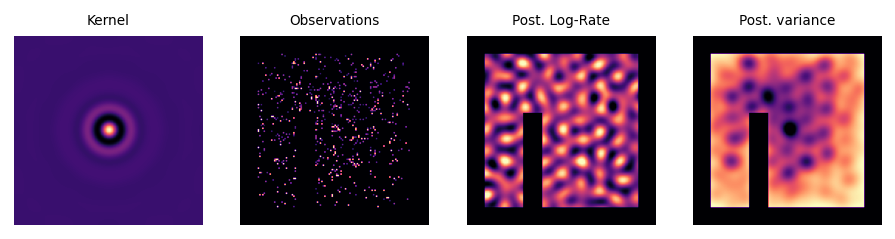

In [411]:
@jit
def loss(μ,v):
    v   = maximum(1e-9,abs(v))
    dv  = vec(conv(v,vkft))
    λ   = sexp(μ+vec(lλb)+0.5*dv)
    ε   = λ - μ*vec(y)
    μΛμ = μ @ vec(conv(μ,Λ0ft))
    return (n@ε + 0.5*(sum(slog(knft)) + diagAΛA@v + μΛμ - sum(slog(v))))/L**2
Jμ = jit(grad(loss,0))
Jv = jit(grad(loss,1))

tic()
v = 1/diagΛ0
μ = lλf.ravel()
mintol = 1e-2
ε = inf
l = inf
print('loss=%e'%loss(μ,v))
for iteration in range(100):
    for i in range(5):
        Hμ = op(L*L, lambda V: grad(lambda μ: vdot(Jμ(μ,v), V))(μ))
        Δμ = -minres(Hμ,Jμ(μ,v),tol=mintol,M=M)[0]
        μ+= Δμ
    εμ = np.mean(abs(Δμ)/abs(μ))
    for i in range(5):
        Hv = op(L*L, lambda V: grad(lambda v: vdot(Jv(μ,v), V))(v))
        Δv = -minres(Hv,Jv(μ,v),tol=mintol)[0]
        v+= Δv
        v = np.maximum(1e-5,v)
    εv = np.mean(abs(Δv)/abs(v))
    
    oldε = ε
    ε = mean(array([εμ,εv]))
    oldl = l
    l = loss(μ,v)
    print('iteration',iteration,'ε=%e'%ε,'mintol=%e'%mintol,'loss=%e'%l)
    if oldl<l:
        print('Loss increasing, that\'s bad')
        mintol *= 0.5
    if ε<1e-5:
        print('Converged')
        break
    if ε>oldε:
        mintol *= 0.5
tic('elapsed')  
    
subplot(141); showkn(kern,'Kernel');
subplot(142); showim(np0.array(y),'Observations');
subplot(143); showim(μ,'Post. Log-Rate',mask=mask);
subplot(144); showim(G(v),'Post. variance',mask=mask);

print(mean(abs(μ_-μ)/abs(μ_)))
print(mean(abs(v_-v)/abs(v_)))

# Jax, but with analytic Jacobian ? 

In [ ]:
v = 1/diagΛ0
μ = lλf.ravel()

def loss(μ,v):
    v   = maximum(1e-9,abs(v))
    dv  = vec(conv(v,vkft))
    λ   = sexp(μ+vec(lλb)+dv/2)
    ε   = λ - μ*vec(y)
    μΛμ = μ @ vec(conv(μ,Λ0ft))
    return n@ε + 0.5*(sum(slog(knft)) + diagAΛA@v + μΛμ - sum(slog(v)))

mintol = 1e-2
ε = inf
l = inf
print('loss=%e'%loss(μ,v))
for iteration in range(100):
    
    dv = conv(v,vkft).ravel()
    λcorrection = n*sexp(vec(lλb)+dv/2)
    def Jμ(μ):
        nλ = λcorrection*sexp(μ)
        return conv(μ,Λ0ft).ravel() + nλ - n*vec(y)
    for i in range(5):
        Hμ = op(L*L, lambda V: grad(lambda μ: vdot(Jμ(μ), V))(μ))
        Δμ = -minres(Hμ,Jμ(μ),tol=mintol,M=M)[0]
        μ += Δμ
    εμ = np.mean(abs(Δμ)/abs(μ))
        
    def Jv(v):
        dv = conv(v,vkft).ravel()#G@v
        nλ = n*sexp(μ+vec(lλb)+dv/2)
        Gnλ = conv(nλ,vkft).ravel() #G@nλ
        return 0.5*(Gnλ+diagAΛA-1/dv)
    for i in range(5):
        Hv = op(L*L, lambda V: grad(lambda v: vdot(Jv(v), V))(v))
        Δv = -minres(Hv,Jv(v),tol=mintol)[0]
        v += Δv
        v  = np.maximum(1e-5,v)
    εv = np.mean(abs(Δv)/abs(v))
    
    oldε = ε
    ε = mean(array([εμ,εv]))
    oldl = l
    l = loss(μ,v)
    print('iteration',iteration,'ε=%e'%ε,'mintol=%e'%mintol,'loss=%e'%l)
    if oldl<l:
        print('Loss increasing, that\'s bad')
        mintol *= 0.5
    if ε<1e-5:
        print('Converged')
        break
    if ε>oldε:
        mintol *= 0.5
    
subplot(141); showkn(kern,'Kernel');
subplot(142); showim(np0.array(y),'Observations');
subplot(143); showim(μ,'Post. Log-Rate',mask=mask);
subplot(144); showim(G(v),'Post. variance',mask=mask);

print(mean(abs(μ_-μ)/abs(μ_)))
print(mean(abs(v_-v)/abs(v_)))

loss=9.395976e+07
iteration 0 ε=3.330582e+00 mintol=1.000000e-02 loss=-1.098468e+04
iteration 1 ε=1.380989e+01 mintol=1.000000e-02 loss=1.094806e+06
Loss increasing, that's bad
iteration 2 ε=1.702763e+00 mintol=2.500000e-03 loss=-2.004863e+04
iteration 3 ε=6.474261e-02 mintol=2.500000e-03 loss=-2.418682e+04
iteration 4 ε=4.568849e-02 mintol=2.500000e-03 loss=-2.578786e+04
iteration 5 ε=6.369407e-01 mintol=2.500000e-03 loss=-2.749178e+04
iteration 6 ε=1.441022e-01 mintol=1.250000e-03 loss=-2.793837e+04
iteration 7 ε=1.803896e+02 mintol=1.250000e-03 loss=-2.811430e+04
iteration 8 ε=2.574839e-02 mintol=6.250000e-04 loss=-2.818207e+04
iteration 9 ε=1.792010e-02 mintol=6.250000e-04 loss=-2.820317e+04
iteration 10 ε=5.389746e-02 mintol=6.250000e-04 loss=-2.820996e+04
iteration 11 ε=3.859027e-03 mintol=3.125000e-04 loss=-2.821117e+04
iteration 12 ε=4.255839e-03 mintol=3.125000e-04 loss=-2.821190e+04
iteration 13 ε=1.793515e-03 mintol=1.562500e-04 loss=-2.821213e+04
iteration 14 ε=4.275252e-03

-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----

In [8]:
# Rank of low-rank approximation 
R = 1

def Λ0(X):
    X2D   = X.reshape(L,L,R)      # LLR
    Xft   = fft2(X2D,axes=(0,1))  # LLR ft
    Λ0Xft = Λ0ft * Xft            # Λ0ft is LL → LLR
    Λ0X   = ifft2(X2D,axes=(0,1)) # LLR
    return vec(real(Λ0X))

Λ0 = op(L**2*R,Λ0)

# This term enters into the variance optimization
k2      = Λ0ft*vkft
diagΛ0  = mean(Λ0ft)*ones(L*L)
diagAΛA = mean(k2)*ones(L*L)

def loss(μ,X):
    v  = np.maximum(1e-9,sum(X**2,axis=1))
    XtX = X.T@X
    λ   = sexp(μ+lλb.ravel()+0.5*dv)
    ε   = λ - μ*y.ravel()
    μΛμ = μ @ conv(μ, Λ0ft).ravel()
    
    trΛ0XXt = sum((Λ0@X)*vec(X))
    return n@ε + μΛμ + 0.5*logdetpsd(XtX) + trΛ0XXt

# Use firing rate as an initial guess for posterior variance
# Incorporate this as a variance correction 
μ = lλf.ravel()
v = 1/diagΛ0
σz = sqrt(v)
X  = σz.reshape(L*L,R)

for iteration in range(10):
    print('iteration',iteration)
    
    # Optimize mean (always the same)
    for i in range(5):
        v  = np.maximum(1e-9,sum(X**2,axis=1))
        nλ = n*sexp(μ+lλb.ravel()+v/2)
        Hμ = Λ0 + diagop(nλ)
        Jμ = conv(μ,Λ0ft).ravel()+nλ-n*y.ravel()
        Δμ = -minres(Hμ,Jμ,tol=1e-5,M=M)[0]
        μ+= Δμ
        εμ = np.max(abs(Δμ)/μ)
        if εμ<1e-5: break
    
    print('.')
    # Optimize covariance 
    for i in range(5):
        v  = np.maximum(1e-9,sum(X**2,axis=1))
        nλ = diagop(n*sexp(μ+vec(lλb)+v/2))
        Xi = pinv(X)
        Q0 = nλ+Λ0
        Jv = Q0@X - Xi.T
        
        XiXit = Xi@Xi.T
        def Hv(M):
            '''
            X and M have shape L²R
            X⁺ has shape RL²
            Do not create a L²xL² matrix
            
            X⁺' M'  X⁺'
            L²R RL² L²R
            
            M   Xi  Xi'
            L²R RL² L²R
            
            Xi' X'  M   Xi  Xi'
            L²R RL² L²R RL² L²R
            
            L²R² → RR; R³
            '''
            M      = array(M).reshape(L*L,R)
            XtM    = X.T @ M
            result = Q0 @ M + Xi.T @ (M.T @ Xi.T + XtM @ XiXit) - M @ XiXit 
            return vec(result)
        
        Hv = op(L**2*R,Hv)
        Δv = -minres(Hv,Jv,tol=1e-5)[0]
        v+= Δv
        v = np.maximum(1e-5,v)
        εv = np.max(abs(Δv)/v)
        if εv<1e-5: break
    ε = max(array([εμ,εv]))
    if ε<1e-4:
        print('Converged')
        break
        
subplot(141); showkn(kern,'Kernel');
subplot(142); showim(y,'Observations');
subplot(143); showim(μ,'Post. Log-Rate',mask=mask);
subplot(144); showim(G(v),'Post. variance',mask=mask);

iteration 0
.


KeyboardInterrupt: 

In [ ]:
def Hv(M):
    '''
    X and M have shape L²R
    X⁺ has shape RL²
    Do not create a L²xL² matrix

    X⁺' M'  X⁺'
    L²R RL² L²R

    M   Xi  Xi'
    L²R RL² L²R

    Xi' X'  M   Xi  Xi'
    L²R RL² L²R RL² L²R

    L²R² → RR; R³
    '''
    M      = array(M).reshape(L*L,R)
    XtM    = X.T @ M
    result = Q0 @ M + Xi.T @ (M.T @ Xi.T + XtM @ XiXit) - M @ XiXit 
    return vec(result)

Hv = op(L**2*R,Hv)

In [ ]:
X = randn(L*L*R)

In [ ]:
Hv @ X

In [ ]:
# Rank of low-rank approximation 
R = 1

def Λ0(X):
    X2D   = X.reshape(L,L,R)      # LLR
    Xft   = fft2(X2D,axes=(0,1))  # LLR ft
    Λ0Xft = Λ0ft * Xft            # Λ0ft is LL → LLR
    Λ0X   = ifft2(X2D,axes=(0,1)) # LLR
    return vec(real(Λ0X))

Λ0 = op(L**2*R,Λ0)

# This term enters into the variance optimization
k2      = Λ0ft*vkft
diagΛ0  = mean(Λ0ft)*ones(L*L)
diagAΛA = mean(k2)*ones(L*L)

def loss(μ,X):
    v  = np.maximum(1e-9,sum(X**2,axis=1))
    XtX = X.T@X
    λ   = sexp(μ+lλb.ravel()+0.5*dv)
    ε   = λ - μ*y.ravel()
    μΛμ = μ @ conv(μ, Λ0ft).ravel()
    
    trΛ0XXt = sum((Λ0@X)*vec(X))
    return n@ε + μΛμ + 0.5*logdetpsd(XtX) + trΛ0XXt

# Use firing rate as an initial guess for posterior variance
# Incorporate this as a variance correction 
μ = lλf.ravel()
v = 1/diagΛ0
σz = sqrt(v)
X  = σz.reshape(L*L,R)

for iteration in range(10):
    print('iteration',iteration)
    
    # Optimize mean (always the same)
    for i in range(5):
        v  = np.maximum(1e-9,sum(X**2,axis=1))
        nλ = n*sexp(μ+lλb.ravel()+v/2)
        Hμ = Λ0 + diagop(nλ)
        Jμ = conv(μ,Λ0ft).ravel()+nλ-n*y.ravel()
        Δμ = -minres(Hμ,Jμ,tol=1e-5,M=M)[0]
        μ+= Δμ
        εμ = np.max(abs(Δμ)/μ)
        if εμ<1e-5: break
    
    print('.')
    # Optimize covariance 
    for i in range(5):
        v  = np.maximum(1e-9,sum(X**2,axis=1))
        nλ = diagop(n*sexp(μ+vec(lλb)+v/2))
        Xi = pinv(X)
        Q0 = nλ+Λ0
        Jv = Q0@X - Xi.T
        
        XiXit = Xi@Xi.T
        def Hv(M):
            '''
            X and M have shape L²R
            X⁺ has shape RL²
            Do not create a L²xL² matrix
            
            X⁺' M'  X⁺'
            L²R RL² L²R
            
            M   Xi  Xi'
            L²R RL² L²R
            
            Xi' X'  M   Xi  Xi'
            L²R RL² L²R RL² L²R
            
            L²R² → RR; R³
            '''
            M      = array(M).reshape(L*L,R)
            XtM    = X.T @ M
            result = Q0 @ M + Xi.T @ (M.T @ Xi.T + XtM @ XiXit) - M @ XiXit 
            return vec(result)
        
        Hv = op(L**2*R,Hv)
        Δv = -minres(Hv,Jv,tol=1e-5)[0]
        v+= Δv
        v = np.maximum(1e-5,v)
        εv = np.max(abs(Δv)/v)
        if εv<1e-5: break
    ε = max(array([εμ,εv]))
    if ε<1e-4:
        print('Converged')
        break
        
subplot(141); showkn(kern,'Kernel');
subplot(142); showim(y,'Observations');
subplot(143); showim(μ,'Post. Log-Rate',mask=mask);
subplot(144); showim(G(v),'Post. variance',mask=mask);

In [ ]:
I